In [1]:
import csv
from os import listdir
from os.path import isfile, isdir, join,abspath
import os
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
mypath = "EMGdata/0809"# 指定要列出所有檔案的目錄
patient='chiu0809'     #病人名稱，後面可加日期加以區分
folder=patient+'/'+patient  #要存放輸出結果的資料夾+病人名稱
test=['02','44','47','80','82'] #檔案的數字編號
label=['pre', 'h1', 'h2','h3','h4'] #採集資料的時間區段名稱
le =  [0,870,400,410,120]    #病人在不同時段的levodopa值
U  =  [46, 38.5,24,32,39.5]              #病人在不同時段的UPDRS值
levodopa_on=True     #有無需要計算包含levodopa的相關矩陣
UPDRS_on=True      #有無需要計算包含UPDRS的相關矩陣
testname='Test'       #檔案名稱裡包含數字編號前的字串
testorder=2           #在檔案名稱中的幾個順序裡有檔案數字


In [3]:
dir=(patient)  #EMG檔案的存放位置
if not os.path.exists(dir):
         os.mkdir(dir)

# 列出所有檔案

In [4]:
for filename in listdir(mypath):
    fullpath = join(mypath,filename)
    print(fullpath)

EMGdata/0809\20220809_chiu_Test02-10_Plot_and_Store_Rep_1.7.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-1_Plot_and_Store_Rep_1.3.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-2_Plot_and_Store_Rep_1.3.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-3_Plot_and_Store_Rep_1.3.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-4_Plot_and_Store_Rep_1.5.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-5_Plot_and_Store_Rep_1.5.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-6_Plot_and_Store_Rep_1.5.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-7_Plot_and_Store_Rep_1.6.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-8_Plot_and_Store_Rep_1.6.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test02-9_Plot_and_Store_Rep_1.6.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test44-10_Plot_and_Store_Rep_1.8.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test44-1_Plot_and_Store_Rep_1.8.csv_Result.xlsx
EMGdata/0809\20220809_chiu_Test44-2_Plot_and_Store_Rep_1.8.csv_Result.xlsx
EMGdata/0809\20220809_c

# 確認檔案數字有在檔案名稱裡

In [5]:
fullpath.split("_")[testorder]

'Test82-9'

In [6]:
df = pd.DataFrame()
 
data = pd.read_excel(fullpath, sheet_name=None)
 
sheet = pd.ExcelFile(fullpath)

# EMG檔案裡的指標名稱

In [7]:
sheet.sheet_names

['Ku', 'CD', 'PSD_3_to_7', 'PSD_12_to_30', 'PSD_20_to_40']

# 取得EMG資料裡１６個頻道的指標的函式

In [8]:
def getburst(data):
    burstduration=[]
    burstdurationsd=[]
    burstinterval=[]
    burstintervalsd=[]   
    df=data.get('Ku')
    Bi=[]
    Bd=[]
    for num in range(16):
        bd=[]
        bi=[]
        val1=0
        val2=0
        for i in range(len(df)):
            n=str(num+1)
            if(df['Off_'+n][i]!=0):
                val1+=1
                bd.append(df['Off_'+n][i]-df['On_'+n][i])   
            if((df['Off_'+n][i]!=0)and(i!=0)):
                bi.append(df['On_'+n][i]-df['Off_'+n][i-1]) 
                val2+=1
        if(val1==0):
            burstduration.append(0)
            burstdurationsd.append(0)
        else:
            burstduration.append(np.mean(bd))
            burstdurationsd.append(np.std(bd))
        if(val2==0):
            burstinterval.append(0)
            burstintervalsd.append(0)
        else:
            burstintervalsd.append(np.std(bi))
            burstinterval.append(np.mean(bi))
        Bi.append(bi)
        Bd.append(bd)
    return (burstduration,burstdurationsd,burstinterval,burstintervalsd,Bi,Bd)

In [9]:
def get_ku(data):
    Ku=[]
    df1=data.get('Ku')
    Kustd=[]   
    Kudata=[]
    for num in range(16):
        ku=[]  
        val=0
        for i in range(len(df1)):
            n=str(num+1)
            if(df1['Ku_'+n][i]!=0):
                val+=1
                ku.append(df1['Ku_'+n][i])
        if(val==0):
            Ku.append(0)
        else:
            Ku.append(np.mean(ku))
            Kustd.append(np.std(ku))
        Kudata.append(ku)
    return(Ku,Kustd,Kudata)

In [10]:
def get_corr(data):
    CorrDim=[]
    CorrDimstd=[]
    df1=data.get('CD')   
    corrdata=[]
    for num in range(16):
        cd=[]
        val=0
        for i in range(len(df1)):
            n=str(num+1)
            if(df1['CD_'+n][i]!=0):
                val+=1
                cd.append(df1['CD_'+n][i])
        if(val==0):
            CorrDim.append(0)
        else:
            CorrDim.append(np.mean(cd))
            CorrDimstd.append(np.std(cd))
        corrdata.append(cd)
    return(CorrDim,CorrDimstd,corrdata)

In [11]:
def get_PSD_3_to_7(data):
    PSD_3_to_7=[]
    df1=data.get('PSD_3_to_7')   
    for num in range(16):
        psd=0
        val=0
        for i in range(len(df1)):
            n=str(num+1)
            if(df1['PSD_'+n][i]!=0):
                val+=1
                psd+=df1['PSD_'+n][i]

        PSD_3_to_7.append(psd/val)
    return(PSD_3_to_7)

In [12]:
def get_PSD_12_to_30(data):
    PSD_12_to_30=[]
    df1=data.get('PSD_12_to_30')   
    for num in range(16):
        psd=0
        val=0
        for i in range(len(df1)):
            n=str(num+1)
            if(df1['PSD_'+n][i]!=0):
                val+=1
                psd+=df1['PSD_'+n][i]

        PSD_12_to_30.append(psd/val)
    return(PSD_12_to_30)

In [13]:
def get_PSD_20_to_40(data):
    PSD_20_to_40=[]
    df1=data.get('PSD_20_to_40')    
    for num in range(16):
        psd=0
        val=0
        for i in range(len(df1)):
            n=str(num+1)
            if(df1['PSD_'+n][i]!=0):
                val+=1
                psd+=df1['PSD_'+n][i]

        PSD_20_to_40.append(psd/val)
    return(PSD_20_to_40)

In [14]:
def getData(fullpath):
    df = pd.DataFrame()
    data = pd.read_excel(fullpath, sheet_name=None)
    sheet = pd.ExcelFile(fullpath)
    burstinterval=getburst(data)[0]
    burstduration=getburst(data)[2] 
    CorrDim=get_corr(data)[0]
    ku=get_ku(data)[0]
    PSD_3_to_7=get_PSD_3_to_7(data)
    PSD_12_to_30=get_PSD_12_to_30(data)
    PSD_20_to_40=get_PSD_20_to_40(data)
    
    Data= pd.DataFrame({'test': [patient+'_'+fullpath.split("_")[testorder]]})
    for i in range(16):
        rows=[]
        n=str(i+1)
        rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'kurtosis_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_3_to_7[i]],'PSD_12_to_30_'+n: [PSD_12_to_30[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]]}
        rows=pd.DataFrame.from_dict(rows)
        Data=pd.concat([Data, rows], axis=1)
    Data.set_index("test" , inplace=True)    
    return Data

# 檢視資料

In [15]:
Data= pd.DataFrame()

for filename in listdir(mypath):
    fullpath = join(mypath,filename)
    data=getData(fullpath)
    Data=pd.concat([Data, data], axis=0)

In [16]:
 Data

burstduration_1  burstinterval_1  kurtosis_1  CorrDim_1  \
test                                                                          
chiu0809_Test02-10         0.394429         0.700500    7.555031   1.881337   
chiu0809_Test02-1          1.212000         0.260875    3.996363   1.954590   
chiu0809_Test02-2          0.752162         0.358617    3.924656   2.031795   
chiu0809_Test02-3          0.415056         0.676150    5.596207   1.971355   
chiu0809_Test02-4          0.752071         0.337313    4.561463   1.919023   
chiu0809_Test02-5          0.333417         0.741760    6.522842   1.909109   
chiu0809_Test02-6          0.905571         0.360125    5.663443   2.022377   
chiu0809_Test02-7          0.327571         0.781125    6.226932   1.909499   
chiu0809_Test02-8          0.881226         0.424150    5.152508   1.972616   
chiu0809_Test02-9          0.316643         0.795188    6.757108   1.924295   
chiu0809_Test44-10         1.001857         0.330000    5.225651   1.961097   
chiu0809_Test44-1          0.383379         0.711745    7.425439   1.847085   
chiu0809_Test44-2          0.478500         0.492667    6.139867   1.838881   
chiu0809_Test44-3          0.197000         0.801850   10.144454   1.913248   
chiu0809_Test44-4          1.569618         0.244497    3.687737   1.945305   
chiu0809_Test44-5          0.421773         0.650659    6.283993   1.825605   
chiu0809_Test44-6          0.704424         0.369685    4.339744   2.053572   
chiu0809_Test44-7          0.313157         0.784205    7.358022   1.861245   
chiu0809_Test44-8          1.194750         0.302143    5.055471   1.885707   
chiu0809_Test44-9          0.287250         0.743333    7.471818   1.914639   
chiu0809_Test47-10         0.622454         0.445723    5.589114   1.910886   
chiu0809_Test47-1          0.720429         0.330000    5.223838   1.888970   
chiu0809_Test47-2          0.560218         0.484464    5.231127   1.960756   
chiu0809_Test47-3          0.576813         0.504167    6.310444   1.917958   
chiu0809_Test47-4          0.237250         0.812111    7.098167   1.872448   
chiu0809_Test47-5          0.241312         0.835722    9.615584   1.885658   
chiu0809_Test47-6          0.213044         0.845534    7.479577   1.894764   
chiu0809_Test47-7          0.204245         0.859492    6.132151   1.949213   
chiu0809_Test47-8          0.185693         0.874104    6.338237   1.941101   
chiu0809_Test47-9          2.244789         0.312406    4.471554   1.951091   
chiu0809_Test80-10         0.411500         0.522917   10.726863   1.709172   
chiu0809_Test80-1          0.531563         0.512167    5.924923   1.946917   
chiu0809_Test80-2          0.353177         0.646101    6.076298   1.930983   
chiu0809_Test80-3          0.377500         0.651444    5.511181   1.880154   
chiu0809_Test80-4          0.324333         0.685750    6.473420   1.875678   
chiu0809_Test80-5          0.605615         0.423378    4.610772   1.976229   
chiu0809_Test80-6          0.366496         0.663498    7.891220   1.893063   
chiu0809_Test80-7          0.456041         0.592741   12.341405   1.848295   
chiu0809_Test80-8          0.729427         0.447835    5.706179   1.837977   
chiu0809_Test80-9          0.406815         0.567684   11.879029   1.803662   
chiu0809_Test82-10         0.920889         0.347674    4.984279   1.953641   
chiu0809_Test82-1          0.300313         0.707389    6.668476   1.964191   
chiu0809_Test82-2          0.707929         0.330438    4.185055   1.965573   
chiu0809_Test82-3          0.940542         0.394447    4.271523   1.812865   
chiu0809_Test82-4          0.319875         0.738222    7.214428   1.916586   
chiu0809_Test82-5          1.436600         0.258000    4.856423   2.085522   
chiu0809_Test82-6          0.786643         0.373500    4.412707   1.941212   
chiu0809_Test82-7          0.277139         0.836974    7.123634   1.900645   
chiu0809_Test82-8          0.328352         0.741204    6.493395   1.8

# 將每一channel的指標存到陣列裡的函式

In [17]:
def getsepData(fullpath):
    SepData=[]
    df = pd.DataFrame()
    data = pd.read_excel(fullpath, sheet_name=None)
    sheet = pd.ExcelFile(fullpath)
    burstinterval=getburst(data)[0]
    burstduration=getburst(data)[2] 
    CorrDim=get_corr(data)[0]
    ku=get_ku(data)[0]
    PSD_3_to_7=get_PSD_3_to_7(data)
    PSD_12_to_30=get_PSD_12_to_30(data)
    PSD_20_to_40=get_PSD_20_to_40(data)
    Data= pd.DataFrame({'test': [fullpath.split("_")[testorder]]})
    for i in range(16):
        rows=[]
        n=str(i+1)
        rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_3_to_7[i]],'PSD_12_to_30_'+n: [PSD_12_to_30[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]]}
        rows=pd.DataFrame.from_dict(rows)
        SepData.append(rows)   
    return SepData

# 頻域的指標

In [18]:
def getsepDatafreq(fullpath):
    SepData=[]
    df = pd.DataFrame()
    data = pd.read_excel(fullpath, sheet_name=None)
    sheet = pd.ExcelFile(fullpath)
    burstinterval=getburst(data)[0]
    burstduration=getburst(data)[2] 
    CorrDim=get_corr(data)[0]
    ku=get_ku(data)[0]
    PSD_3_to_7=get_PSD_3_to_7(data)
    PSD_12_to_30=get_PSD_12_to_30(data)
    PSD_20_to_40=get_PSD_20_to_40(data)
    Data= pd.DataFrame({'test': [fullpath.split("_")[testorder]]})
    for i in range(16):
        rows=[]
        n=str(i+1)
        rows={'PSD_3_to_7_'+n: [PSD_12_to_30[i]],'PSD_12_to_30_'+n: [PSD_3_to_7[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]]}
        rows=pd.DataFrame.from_dict(rows)
        SepData.append(rows)
    return SepData

# 時域的指標

In [19]:
def getsepDatatime(fullpath):
    SepData=[]
    df = pd.DataFrame()
    data = pd.read_excel(fullpath, sheet_name=None)
    sheet = pd.ExcelFile(fullpath)
    burstinterval=getburst(data)[0]
    burstduration=getburst(data)[2] 
    CorrDim=get_corr(data)[0]
    ku=get_ku(data)[0]
    PSD_3_to_7=get_PSD_3_to_7(data)
    PSD_12_to_30=get_PSD_12_to_30(data)
    PSD_20_to_40=get_PSD_20_to_40(data)
    #
    Data= pd.DataFrame({'test': [fullpath.split("_")[testorder]]})
    for i in range(16):
        rows=[]
        n=str(i+1)
        rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] }
        rows=pd.DataFrame.from_dict(rows)
        SepData.append(rows)
  
    return SepData

# 加入血液濃度或UPDRS

In [20]:
def getcorData(fullpath):
    for i in range(len(test)):
        #may change
        if((testname+test[i]) in fullpath.split("_")[testorder]):
            if(levodopa_on&UPDRS_on):
                UPDRS=U[i]   
                levodopa=le[i]  
            elif(levodopa_on&(not UPDRS_on)): 
                levodopa=le[i] 
            elif((not levodopa_on)&UPDRS_on): 
                UPDRS=U[i]   
    SepData=[]
    df = pd.DataFrame()
    data = pd.read_excel(fullpath, sheet_name=None)
    burstinterval=getburst(data)[0]
    burstduration=getburst(data)[2] 
    CorrDim=get_corr(data)[0]
    ku=get_ku(data)[0]
    PSD_3_to_7=get_PSD_3_to_7(data)
    PSD_12_to_30=get_PSD_12_to_30(data)
    PSD_20_to_40=get_PSD_20_to_40(data)
    Data= pd.DataFrame({'test': [fullpath.split("_")[testorder]]})
    for i in range(16):
        rows=[]
        n=str(i+1)
        if(levodopa_on&UPDRS_on):
            rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_12_to_30[i]],'PSD_12_to_30_'+n: [PSD_3_to_7[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]],'levodopa_'+n:levodopa,'UPDRS_'+n:UPDRS}
        elif(levodopa_on&(not UPDRS_on)):    
            rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_12_to_30[i]],'PSD_12_to_30_'+n: [PSD_3_to_7[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]],'levodopa_'+n:levodopa}
        elif((not levodopa_on)&UPDRS_on):    
            rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_12_to_30[i]],'PSD_12_to_30_'+n: [PSD_3_to_7[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]],'UPDRS_'+n:UPDRS}
        else:
            rows={'burstduration_'+n: [burstduration[i]],'burstinterval_'+n: [burstinterval[i]],'Ku_'+n: [ku[i]],'CorrDim_'+n: [CorrDim[i]] ,'PSD_3_to_7_'+n: [PSD_12_to_30[i]],'PSD_12_to_30_'+n: [PSD_3_to_7[i]], 'PSD_20_to_40_'+n:[PSD_20_to_40[i]]}
        rows=pd.DataFrame.from_dict(rows)
        SepData.append(rows)
    return SepData

# 做出correlation matrix 

C:\Users\huang\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


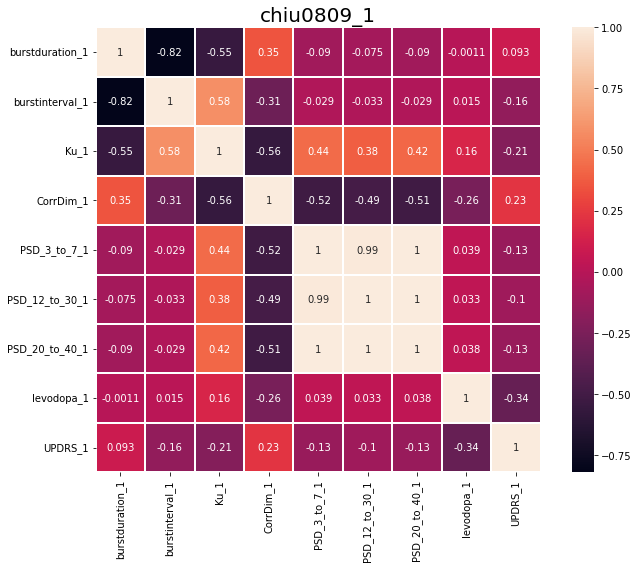

<Figure size 432x288 with 0 Axes>

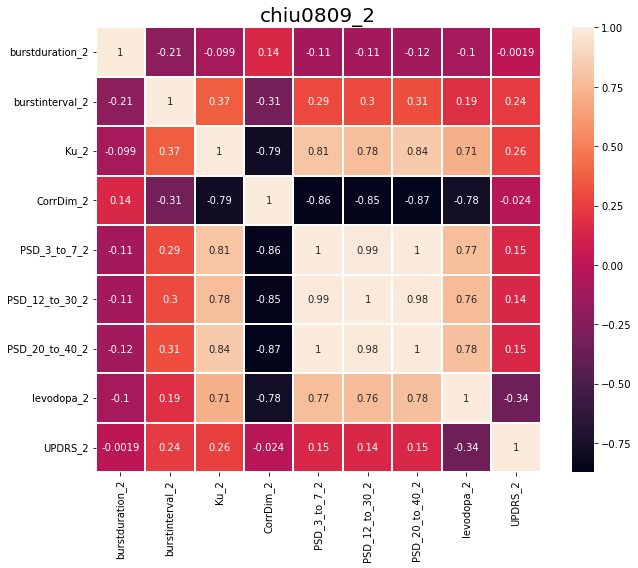

<Figure size 432x288 with 0 Axes>

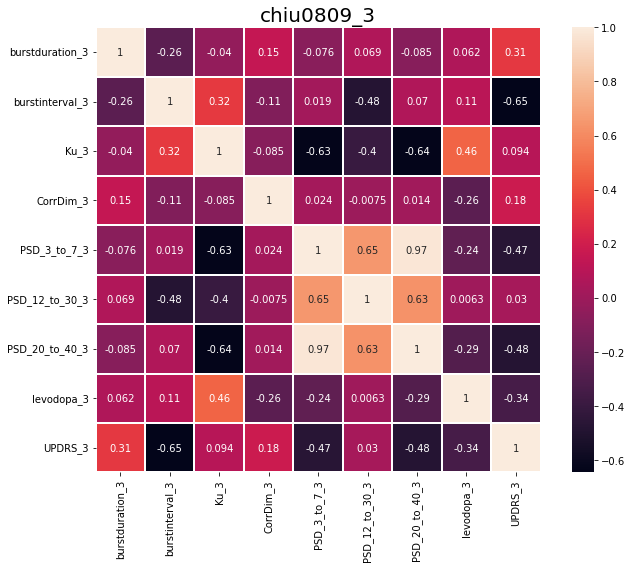

<Figure size 432x288 with 0 Axes>

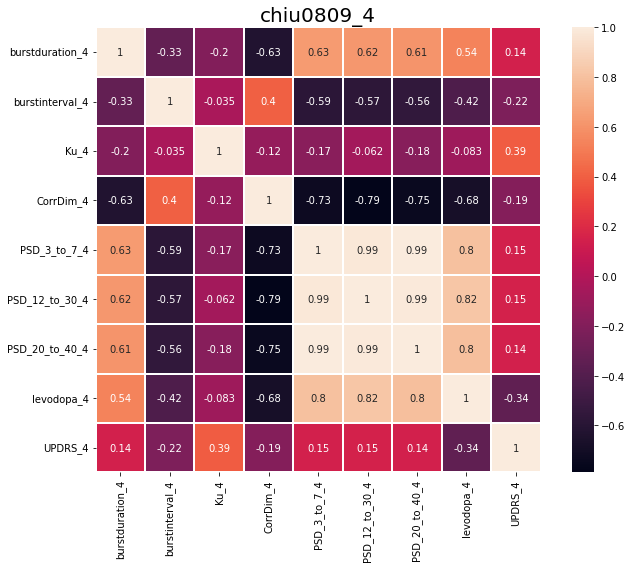

<Figure size 432x288 with 0 Axes>

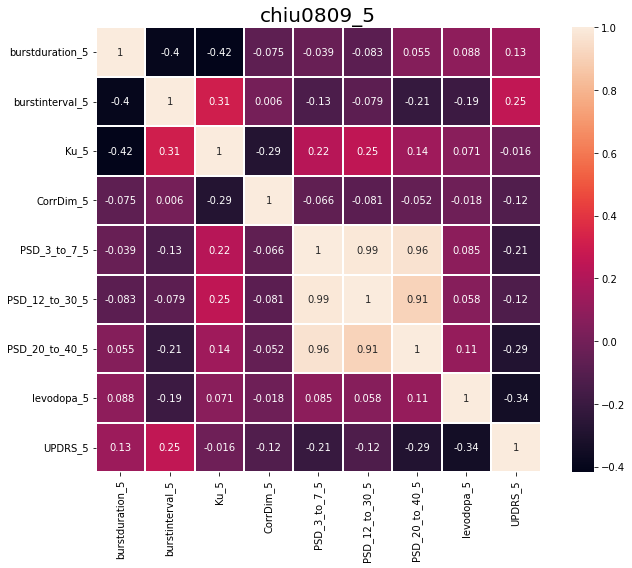

<Figure size 432x288 with 0 Axes>

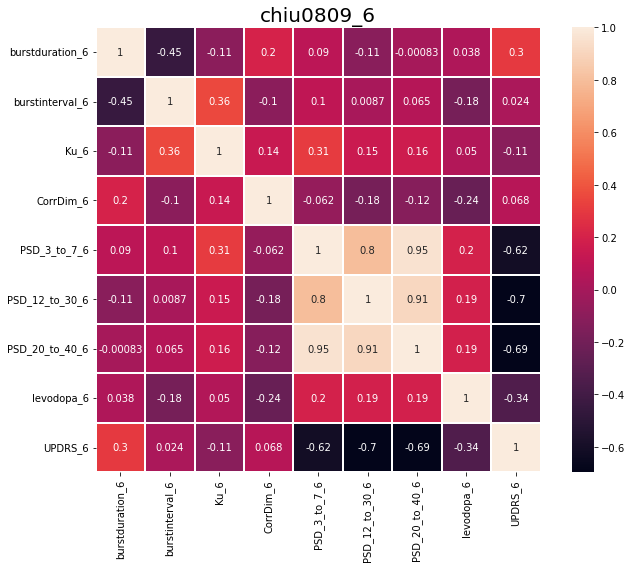

<Figure size 432x288 with 0 Axes>

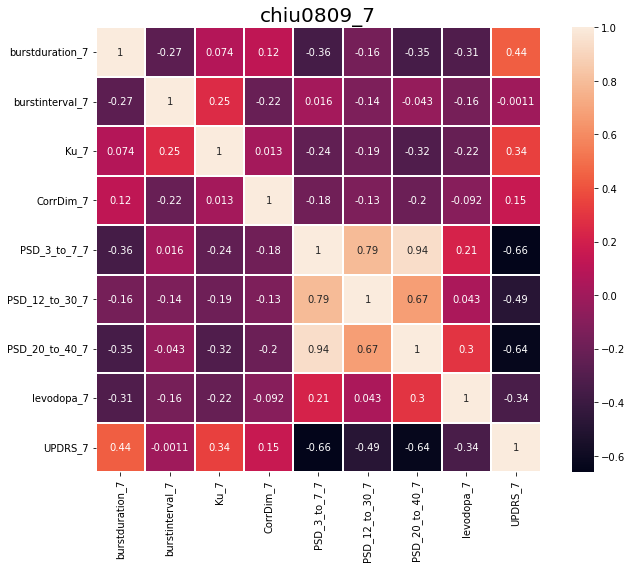

<Figure size 432x288 with 0 Axes>

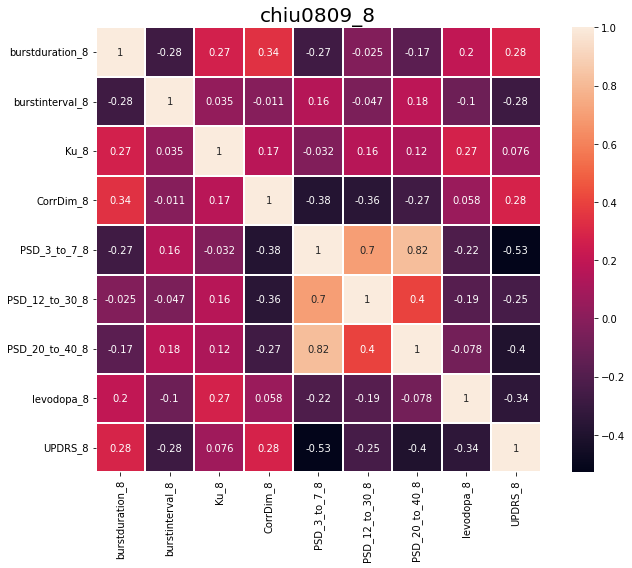

<Figure size 432x288 with 0 Axes>

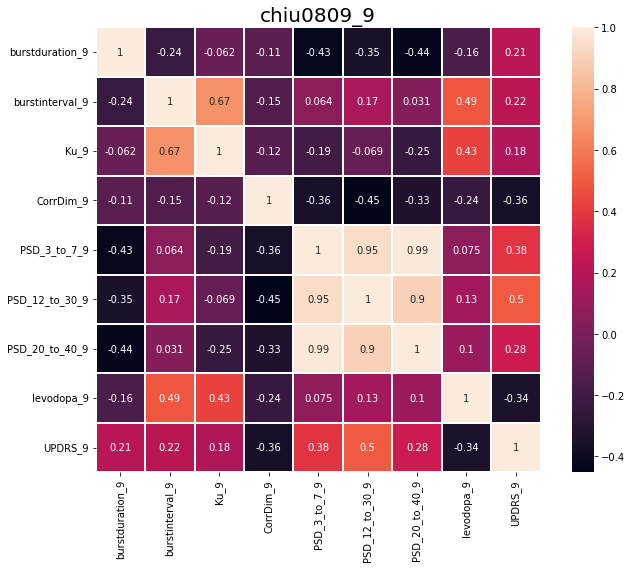

<Figure size 432x288 with 0 Axes>

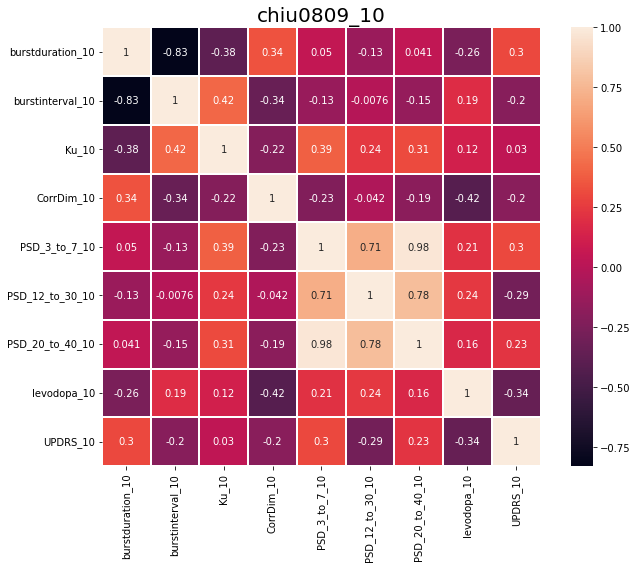

<Figure size 432x288 with 0 Axes>

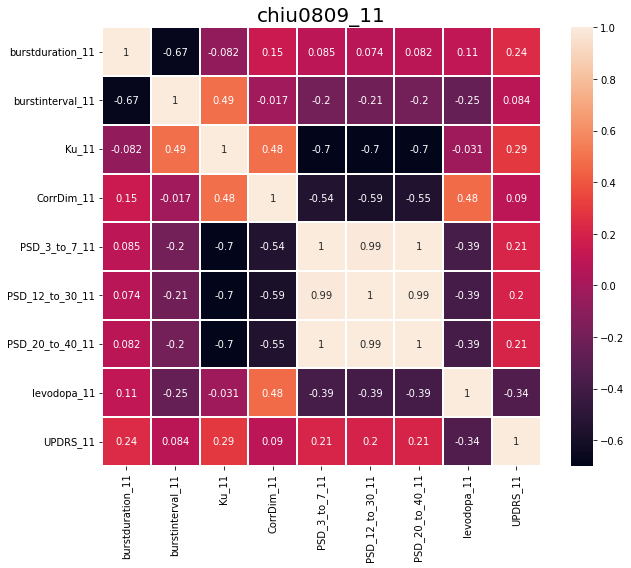

<Figure size 432x288 with 0 Axes>

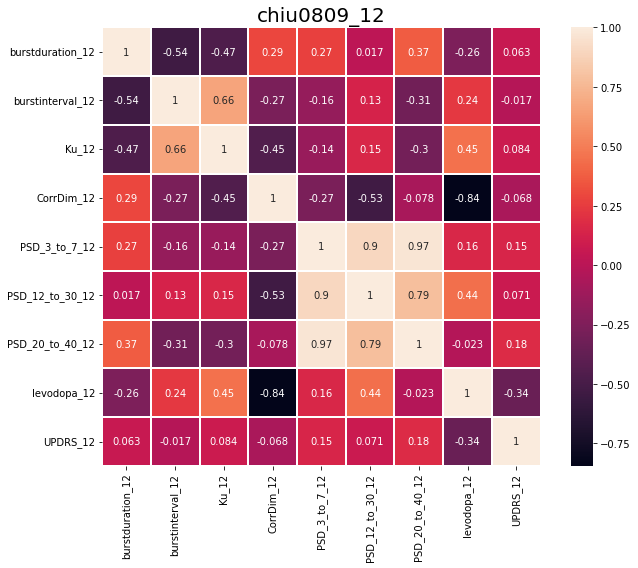

<Figure size 432x288 with 0 Axes>

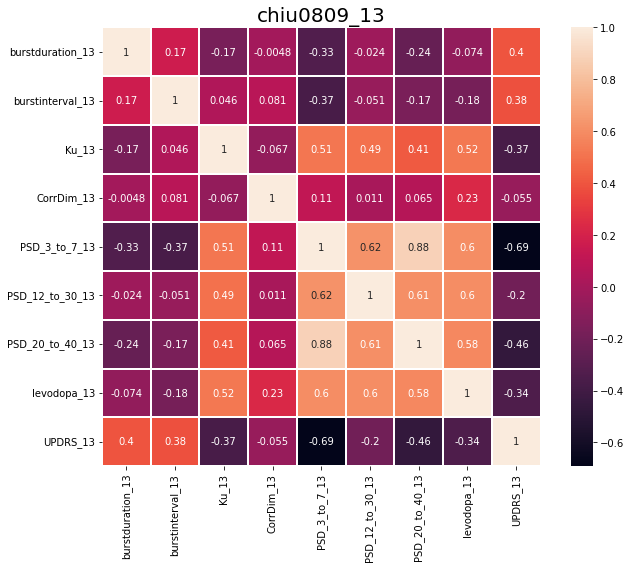

<Figure size 432x288 with 0 Axes>

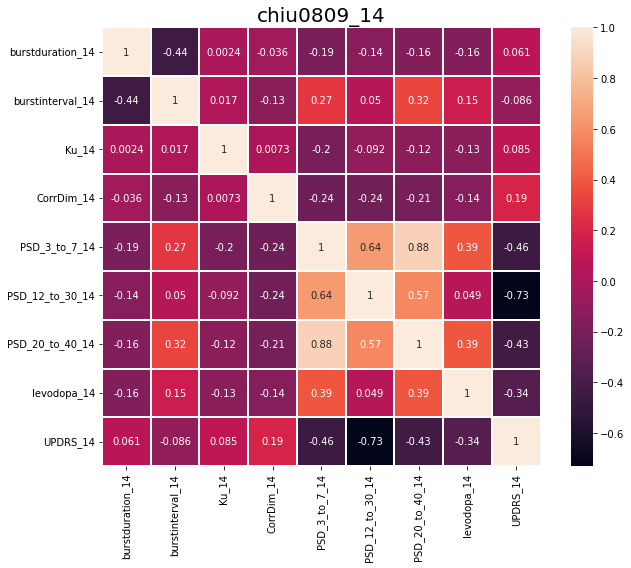

<Figure size 432x288 with 0 Axes>

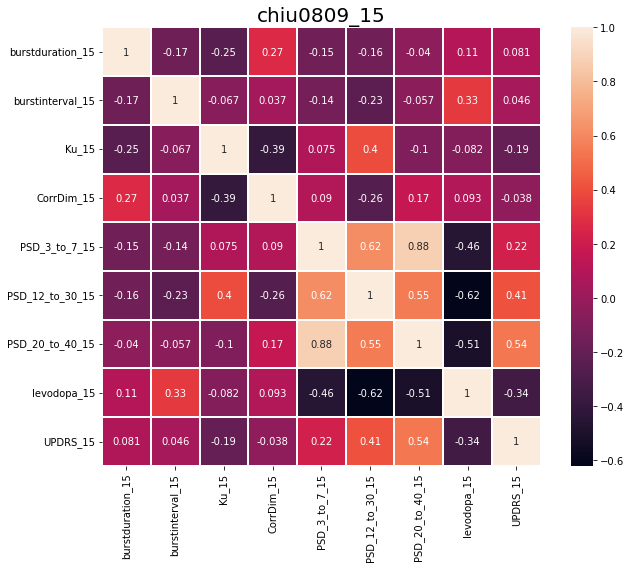

<Figure size 432x288 with 0 Axes>

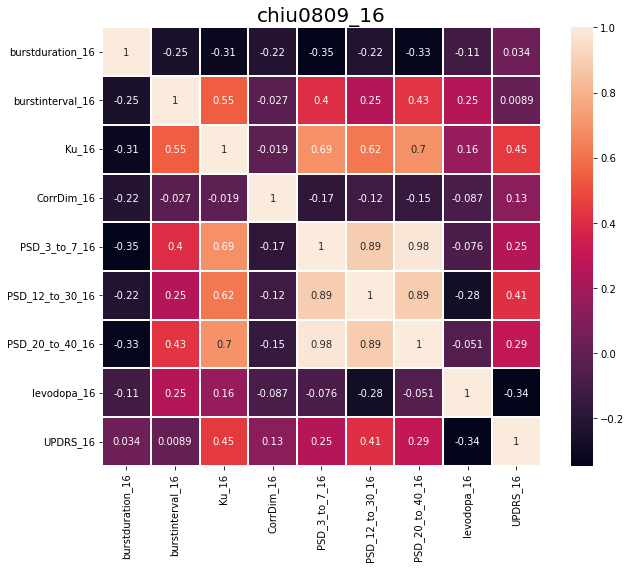

<Figure size 432x288 with 0 Axes>

In [21]:
D=[]

for filename in listdir(mypath): 
    fullpath = join(mypath,filename)
    D.append(getcorData(fullpath))
for i in range(16):
    Data= pd.DataFrame()
    for j in range(len(D)):
        Data=pd.concat([Data, D[j][i]], axis=0)
    corr_matrix = Data.corr()
    corr_matrix.to_csv(folder+'_'+str(i+1)+'.csv')
    plt.figure(figsize = (10,8))
    swarm_plot=sns.heatmap(corr_matrix,linewidths=0.1,vmax=1.0, square=True,linecolor='white', annot=True)
    fig = swarm_plot.get_figure()
    plt.title(patient+'_'+str(i+1), fontsize =20)
    fig.tight_layout()
    fig.savefig(folder+'_'+str(i+1)+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
    plt.figure().clear()
    
    

# PCA

In [22]:
df= pd.DataFrame()

for filename in listdir(mypath):
    fullpath = join(mypath,filename)
    data=getData(fullpath)
    df=pd.concat([df, data], axis=0)

In [23]:
df

burstduration_1  burstinterval_1  kurtosis_1  CorrDim_1  \
test                                                                          
chiu0809_Test02-10         0.394429         0.700500    7.555031   1.881337   
chiu0809_Test02-1          1.212000         0.260875    3.996363   1.954590   
chiu0809_Test02-2          0.752162         0.358617    3.924656   2.031795   
chiu0809_Test02-3          0.415056         0.676150    5.596207   1.971355   
chiu0809_Test02-4          0.752071         0.337313    4.561463   1.919023   
chiu0809_Test02-5          0.333417         0.741760    6.522842   1.909109   
chiu0809_Test02-6          0.905571         0.360125    5.663443   2.022377   
chiu0809_Test02-7          0.327571         0.781125    6.226932   1.909499   
chiu0809_Test02-8          0.881226         0.424150    5.152508   1.972616   
chiu0809_Test02-9          0.316643         0.795188    6.757108   1.924295   
chiu0809_Test44-10         1.001857         0.330000    5.225651   1.961097   
chiu0809_Test44-1          0.383379         0.711745    7.425439   1.847085   
chiu0809_Test44-2          0.478500         0.492667    6.139867   1.838881   
chiu0809_Test44-3          0.197000         0.801850   10.144454   1.913248   
chiu0809_Test44-4          1.569618         0.244497    3.687737   1.945305   
chiu0809_Test44-5          0.421773         0.650659    6.283993   1.825605   
chiu0809_Test44-6          0.704424         0.369685    4.339744   2.053572   
chiu0809_Test44-7          0.313157         0.784205    7.358022   1.861245   
chiu0809_Test44-8          1.194750         0.302143    5.055471   1.885707   
chiu0809_Test44-9          0.287250         0.743333    7.471818   1.914639   
chiu0809_Test47-10         0.622454         0.445723    5.589114   1.910886   
chiu0809_Test47-1          0.720429         0.330000    5.223838   1.888970   
chiu0809_Test47-2          0.560218         0.484464    5.231127   1.960756   
chiu0809_Test47-3          0.576813         0.504167    6.310444   1.917958   
chiu0809_Test47-4          0.237250         0.812111    7.098167   1.872448   
chiu0809_Test47-5          0.241312         0.835722    9.615584   1.885658   
chiu0809_Test47-6          0.213044         0.845534    7.479577   1.894764   
chiu0809_Test47-7          0.204245         0.859492    6.132151   1.949213   
chiu0809_Test47-8          0.185693         0.874104    6.338237   1.941101   
chiu0809_Test47-9          2.244789         0.312406    4.471554   1.951091   
chiu0809_Test80-10         0.411500         0.522917   10.726863   1.709172   
chiu0809_Test80-1          0.531563         0.512167    5.924923   1.946917   
chiu0809_Test80-2          0.353177         0.646101    6.076298   1.930983   
chiu0809_Test80-3          0.377500         0.651444    5.511181   1.880154   
chiu0809_Test80-4          0.324333         0.685750    6.473420   1.875678   
chiu0809_Test80-5          0.605615         0.423378    4.610772   1.976229   
chiu0809_Test80-6          0.366496         0.663498    7.891220   1.893063   
chiu0809_Test80-7          0.456041         0.592741   12.341405   1.848295   
chiu0809_Test80-8          0.729427         0.447835    5.706179   1.837977   
chiu0809_Test80-9          0.406815         0.567684   11.879029   1.803662   
chiu0809_Test82-10         0.920889         0.347674    4.984279   1.953641   
chiu0809_Test82-1          0.300313         0.707389    6.668476   1.964191   
chiu0809_Test82-2          0.707929         0.330438    4.185055   1.965573   
chiu0809_Test82-3          0.940542         0.394447    4.271523   1.812865   
chiu0809_Test82-4          0.319875         0.738222    7.214428   1.916586   
chiu0809_Test82-5          1.436600         0.258000    4.856423   2.085522   
chiu0809_Test82-6          0.786643         0.373500    4.412707   1.941212   
chiu0809_Test82-7          0.277139         0.836974    7.123634   1.900645   
chiu0809_Test82-8          0.328352         0.741204    6.493395   1.8

In [24]:
# 使用 scikit-learn 內建的 API 正規化
scaler = StandardScaler()
Z= scaler.fit_transform(df)  # 注意維度

In [25]:
df.iloc[:, :] = Z

# 印出正規化後的資料

In [26]:
df.head()

burstduration_1  burstinterval_1  kurtosis_1  CorrDim_1  \
test                                                                          
chiu0809_Test02-10        -0.497447         0.687026    0.628742  -0.532944   
chiu0809_Test02-1          1.551926        -1.567266   -1.233572   0.588187   
chiu0809_Test02-2          0.399269        -1.066069   -1.271098   1.769788   
chiu0809_Test02-3         -0.445742         0.562165   -0.396345   0.844776   
chiu0809_Test02-4          0.399042        -1.175313   -0.937845   0.043847   

                    PSD_3_to_7_1  PSD_12_to_30_1  PSD_20_to_40_1  \
test                                                               
chiu0809_Test02-10     -0.188823       -0.220632       -0.216333   
chiu0809_Test02-1      -0.170724       -0.200339       -0.201274   
chiu0809_Test02-2      -0.166345       -0.192359       -0.191741   
chiu0809_Test02-3      -0.182770       -0.234051       -0.239698   
chiu0809_Test02-4      -0.173251       -0.181132       -0.171103   

                    burstduration_2  burstinterval_2  kurtosis_2  ...  \
test                                                              ...   
chiu0809_Test02-10        -0.298639        -1.367827   -0.323995  ...   
chiu0809_Test02-1          0.734581         0.764698    0.311062  ...   
chiu0809_Test02-2         -0.134093         1.538896   -0.381737  ...   
chiu0809_Test02-3          1.010440        -0.219360   -0.926352  ...   
chiu0809_Test02-4          1.220688         0.008739   -0.483333  ...   

                    PSD_3_to_7_15  PSD_12_to_30_15  PSD_20_to_40_15  \
test                                                                  
chiu0809_Test02-10       2.167071         0.516229         1.183606   
chiu0809_Test02-1        0.269811        -0.304893         0.210201   
chiu0809_Test02-2       -0.339754        -0.814111        -0.405176   
chiu0809_Test02-3       -0.364527        -1.145131        -0.647054   
chiu0809_Test02-4        1.729658         0.298367         0.517159   

                    burstduration_16  burstinterval_16  kurtosis_16  \
test                                                                  
chiu0809_Test02-10          0.337063          0.867154    -0.998863   
chiu0809_Test02-1          -0.548964          0.693410     1.829737   
chiu0809_Test02-2          -0.182930          1.226098     0.430016   
chiu0809_Test02-3          -0.676237         -0.462449     1.528866   
chiu0809_Test02-4          -0.579708          1.820344     1.557955   

                    CorrDim_16  PSD_3_to_7_16  PSD_12_to_30_16  \
test                                                             
chiu0809_Test02-10    1.997305      -0.384923        -0.649575   
chiu0809_Test02-1    -1.244288       4.630637         3.748371   
chiu0809_Test02-2     1.006928       0.883967         1.349760   
chiu0809_Test02-3     0.086986       2.862685         1.871888   
chiu0809_Test02-4    -0.426359       2.667178         2.235473   

                    PSD_20_to_40_16  
test                                 
chiu0809_Test02-10        -0.316683  
chiu0809_Test02-1          4.192880  
chiu0809_Test02-2          1.330871  
chiu0809_Test02-3          1.697631  
chiu0809_Test02-4          1.936346  

[5 rows x 112 columns]

In [27]:
df_stats = df.describe().loc[['mean', 'std']]
df_stats.style.format("{:.2f}")

In [28]:
df.index

Index(['chiu0809_Test02-10', 'chiu0809_Test02-1', 'chiu0809_Test02-2',
       'chiu0809_Test02-3', 'chiu0809_Test02-4', 'chiu0809_Test02-5',
       'chiu0809_Test02-6', 'chiu0809_Test02-7', 'chiu0809_Test02-8',
       'chiu0809_Test02-9', 'chiu0809_Test44-10', 'chiu0809_Test44-1',
       'chiu0809_Test44-2', 'chiu0809_Test44-3', 'chiu0809_Test44-4',
       'chiu0809_Test44-5', 'chiu0809_Test44-6', 'chiu0809_Test44-7',
       'chiu0809_Test44-8', 'chiu0809_Test44-9', 'chiu0809_Test47-10',
       'chiu0809_Test47-1', 'chiu0809_Test47-2', 'chiu0809_Test47-3',
       'chiu0809_Test47-4', 'chiu0809_Test47-5', 'chiu0809_Test47-6',
       'chiu0809_Test47-7', 'chiu0809_Test47-8', 'chiu0809_Test47-9',
       'chiu0809_Test80-10', 'chiu0809_Test80-1', 'chiu0809_Test80-2',
       'chiu0809_Test80-3', 'chiu0809_Test80-4', 'chiu0809_Test80-5',
       'chiu0809_Test80-6', 'chiu0809_Test80-7', 'chiu0809_Test80-8',
       'chiu0809_Test80-9', 'chiu0809_Test82-10', 'chiu0809_Test82-1',
       'chiu080

# 取得按照時間順序排列的資料

In [29]:
lo=[]
for j in range(len(test)):
    lo.append([])
for i in range(len(df.index)):    
    for j in range(len(test)):
            if((testname+test[j]) in df.index[i]):
                    lo[j].append(i)


In [30]:
lo

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]]

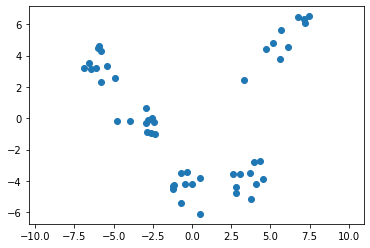

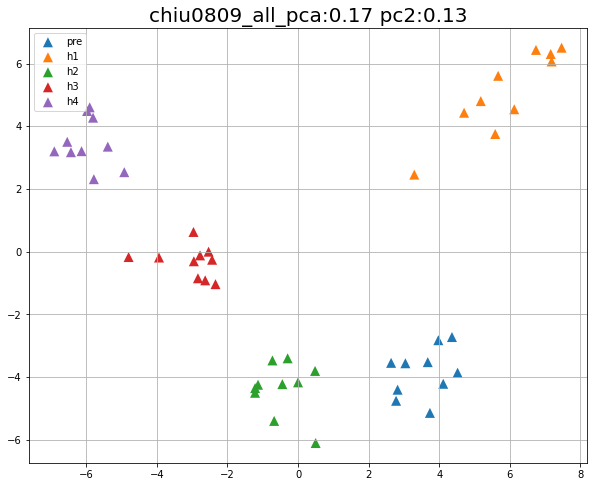

<Figure size 432x288 with 0 Axes>

In [31]:
"""
透過 scikit-learn 將數據降到 2 維
"""
# 我們只要最大的兩個主成分。scikit-learn 會自動幫我們
# 依照 eigenvalue 的大小排序共變異數矩陣的 eigenvectors
n_components = 2
random_state = 9527

pca = PCA(n_components=n_components, 
          random_state=random_state)

# 注意我們是對正規化後的特徵 Z 做 PCA
L = pca.fit_transform(Z)  # (n_samples, n_components)

# 將投影到第一主成分的 repr. 顯示在 x 軸，第二主成分在 y 軸
plt.scatter(L[:, 0], L[:, 1])
plt.axis('equal');
# 將投影到第一主成分的 repr. 顯示在 x 軸，第二主成分在 y 軸，依照不同時間段資料點顏色不同
fig, ax = plt.subplots(figsize=(10,8))

for i in range(len(lo)):
    ax.scatter(L[lo[i],0], L[lo[i],1], label=label[i],marker ="^",
                edgecolors='none',s=100)

eig=np.round(pca.explained_variance_ratio_, 2)

plt.title(patient+'_all_pca:'+str(eig[0])+' pc2:'+str(eig[1]), fontsize =20)

ax.legend()
ax.grid(True)

plt.show()
fig.savefig(folder+'_all_pca'+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
plt.figure().clear()

In [32]:
"""
解析數據的前兩大主成份所代表的意涵。
顏色越突出代表其絕對值越大
"""
pcs = np.array(pca.components_) # (n_comp, n_features)

df_pc = pd.DataFrame(pcs, columns=df.columns[:])
df_pc.index = [f"第{c}主成分" for c in['一', '二']]
df_pc.style\
    .background_gradient(cmap='bwr_r', axis=None)\
    .format("{:.2}")
df_pc.to_csv(folder+'_pc_all'+'.csv', index=False)

# 每一頻道全部指標的PCA

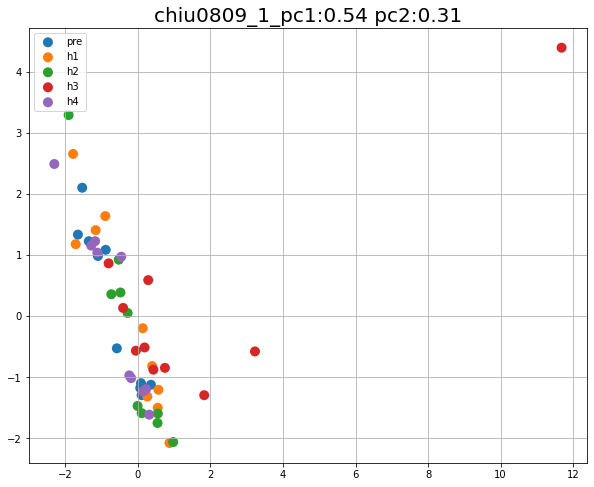

<Figure size 432x288 with 0 Axes>

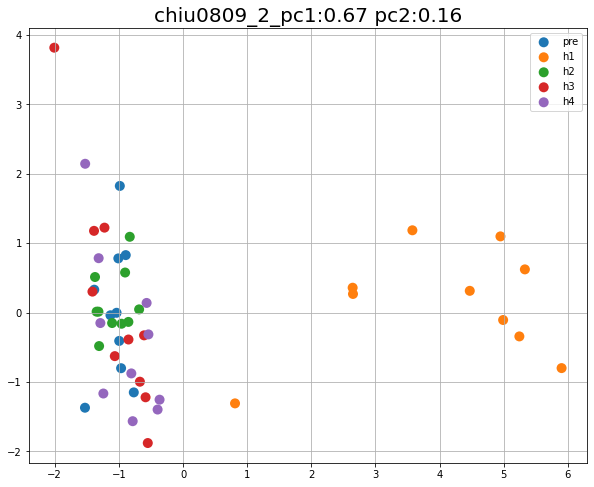

<Figure size 432x288 with 0 Axes>

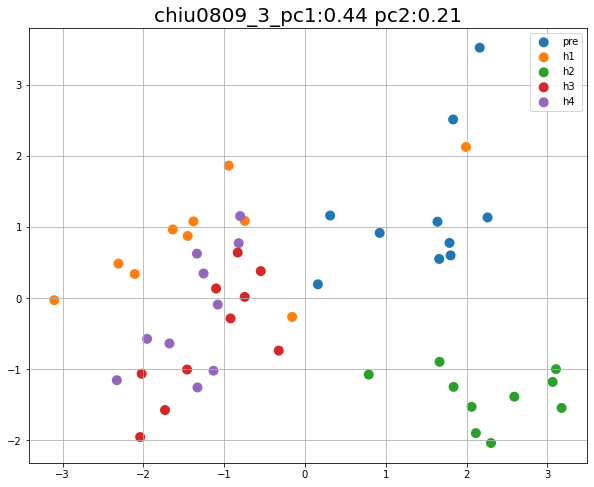

<Figure size 432x288 with 0 Axes>

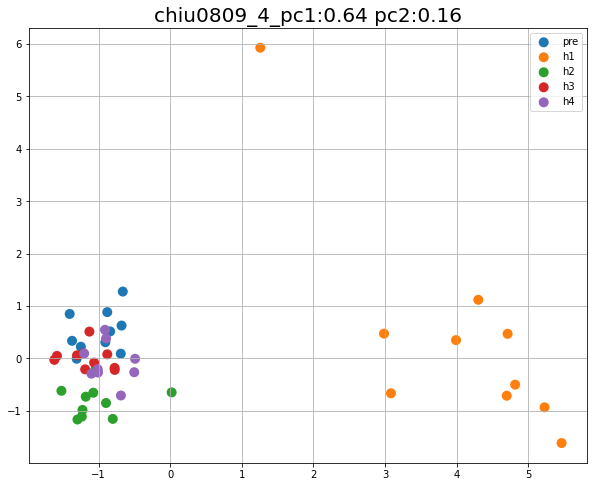

<Figure size 432x288 with 0 Axes>

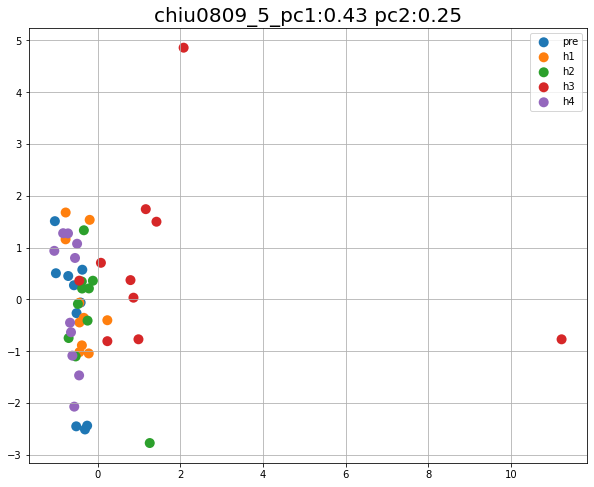

<Figure size 432x288 with 0 Axes>

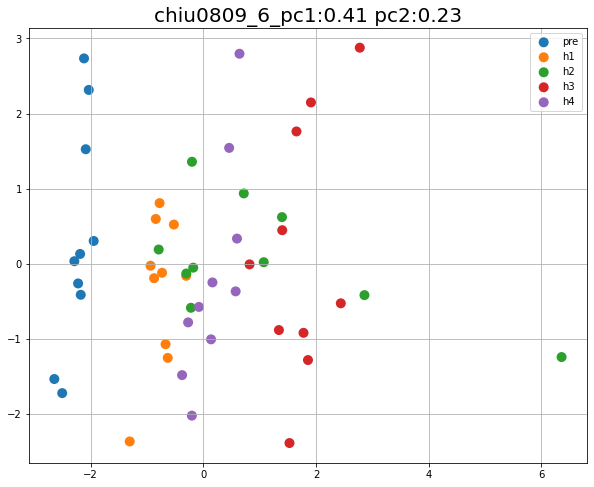

<Figure size 432x288 with 0 Axes>

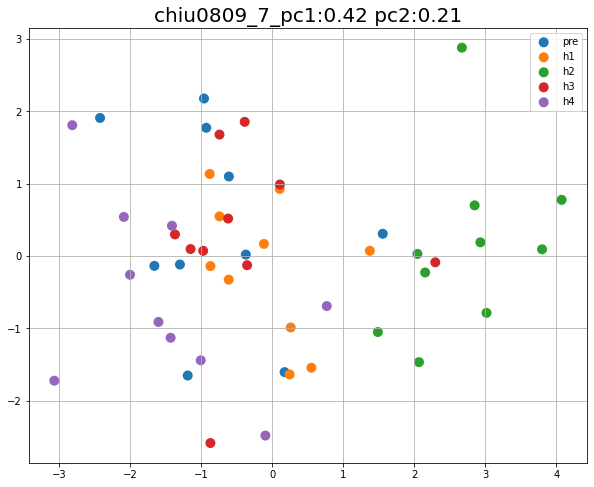

<Figure size 432x288 with 0 Axes>

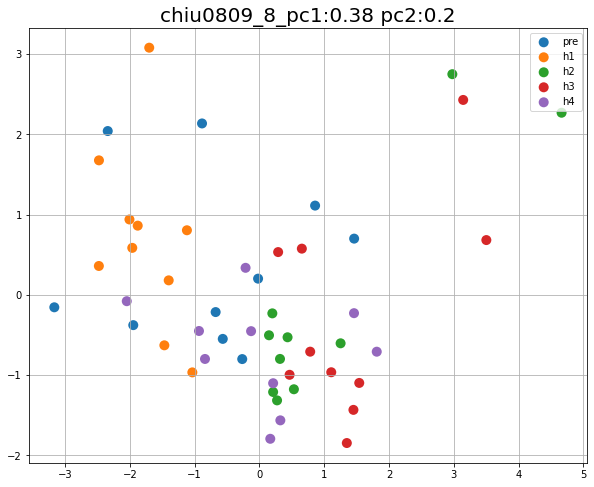

<Figure size 432x288 with 0 Axes>

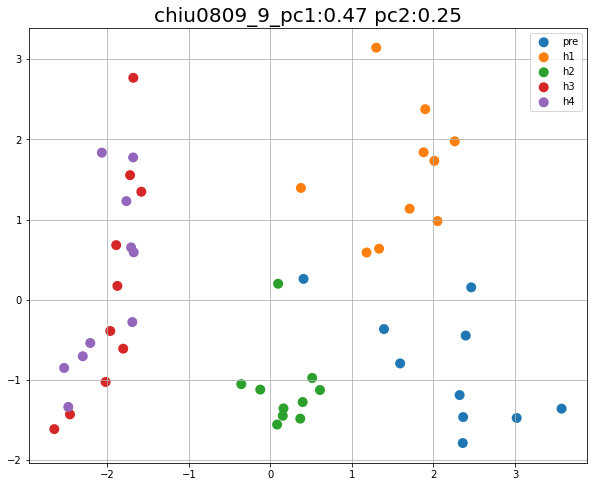

<Figure size 432x288 with 0 Axes>

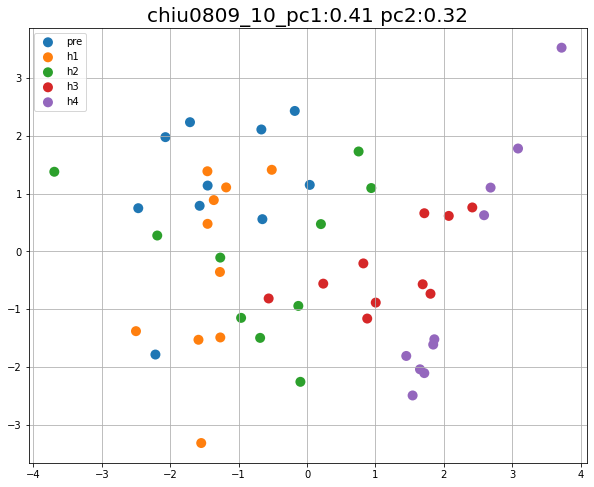

<Figure size 432x288 with 0 Axes>

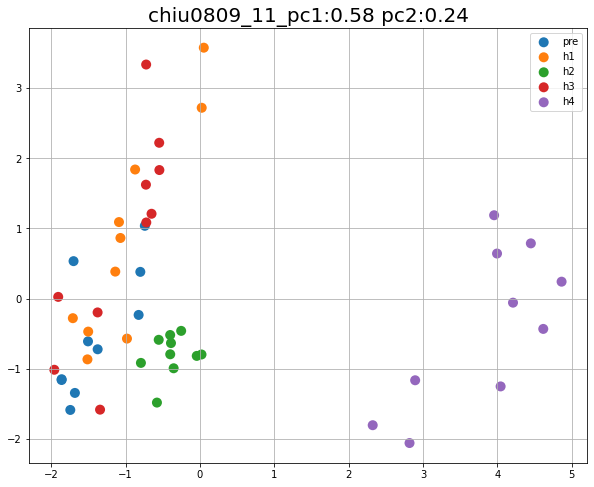

<Figure size 432x288 with 0 Axes>

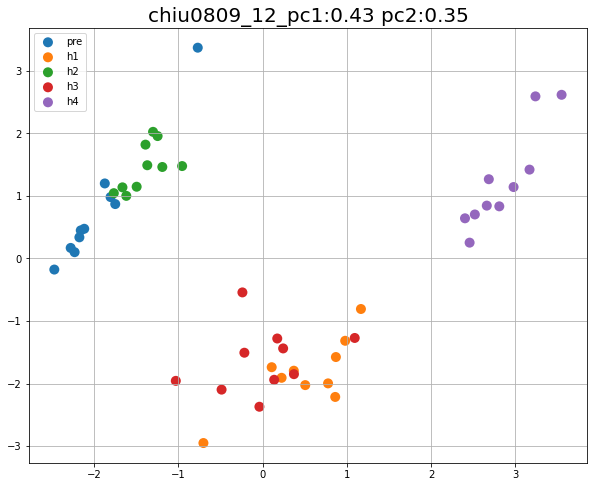

<Figure size 432x288 with 0 Axes>

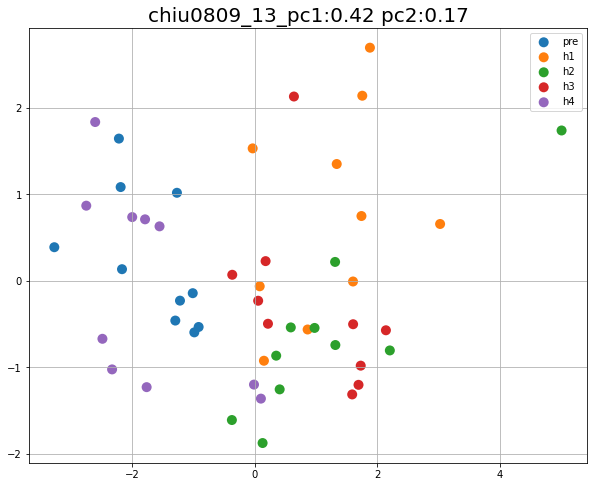

<Figure size 432x288 with 0 Axes>

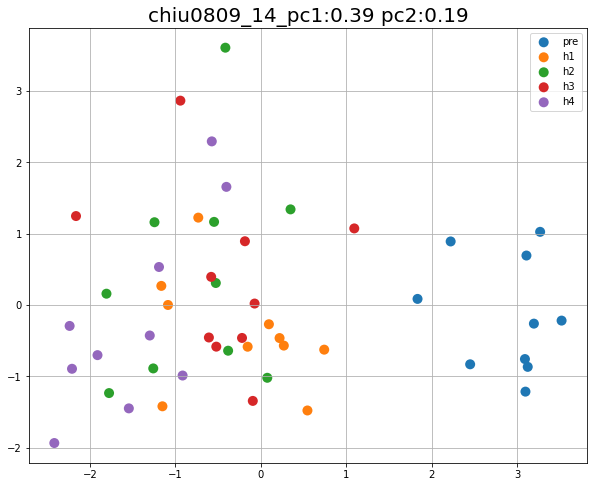

<Figure size 432x288 with 0 Axes>

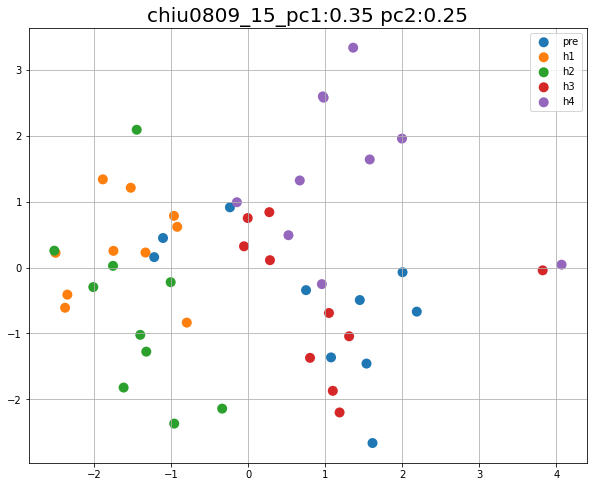

<Figure size 432x288 with 0 Axes>

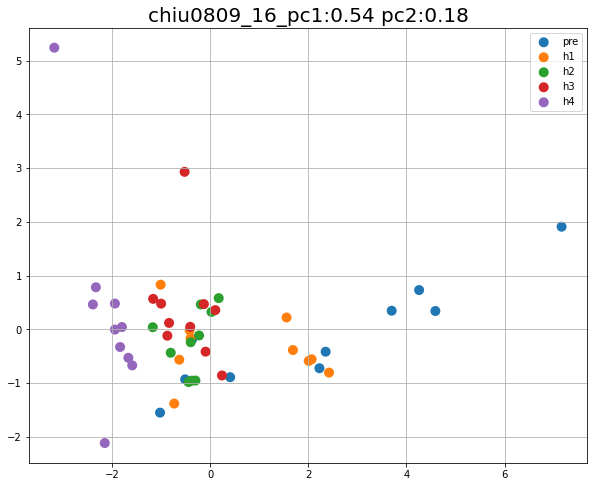

<Figure size 432x288 with 0 Axes>

In [33]:
import seaborn as sns
D=[]
for filename in listdir(mypath): 
    fullpath = join(mypath,filename)
    D.append(getsepData(fullpath))
for i in range(16):
    Data= pd.DataFrame()    
    for j in range(len(D)):
        Data=pd.concat([Data, D[j][i]], axis=0)   
    # 使用 scikit-learn 內建的 API 正規化
    scaler = StandardScaler()
    Z= scaler.fit_transform(Data)  # 注意維度
    
    # 我們只要最大的兩個主成分。scikit-learn 會自動幫我們
    # 依照 eigenvalue 的大小排序共變異數矩陣的 eigenvectors
    n_components = 2
    random_state = 9527
    pca = PCA(n_components=n_components, 
              random_state=random_state)
    # 注意我們是對正規化後的特徵 Z 做 PCA
    L = pca.fit_transform(Z)  # (n_samples, n_components)

    # 將投影到第一主成分的 repr. 顯示在 x 軸，第二主成分在 y 軸
    fig, ax = plt.subplots(figsize=(10,8))
    for j in range(len(lo)):
        ax.scatter(L[lo[j],0], L[lo[j],1], label=label[j],
                    edgecolors='none',s=100)

    s=np.round(pca.explained_variance_ratio_, 2)
    plt.title(patient+'_'+str(i+1)+'_pc1:'+str(s[0])+' pc2:'+str(s[1]), fontsize =20)
    
    ax.legend()
    ax.grid(True)
    plt.show()
    pcs = np.array(pca.components_) # (n_comp, n_features)
    df_pc = pd.DataFrame(pcs, columns=Data.columns[:])
    df_pc.index = [f"{i+1}cha_{c}_component" for c in['one', 'second']]
    df_pc.style\
        #.background_gradient(cmap='bwr_r', axis=None)\
        #.format("{:.2}")
    df_pc.to_csv(folder+'_df'+str(i+1)+'.csv')
    
    fig.savefig(folder+'_pca'+str(i+1)+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
    plt.figure().clear()

# pca_頻域指標

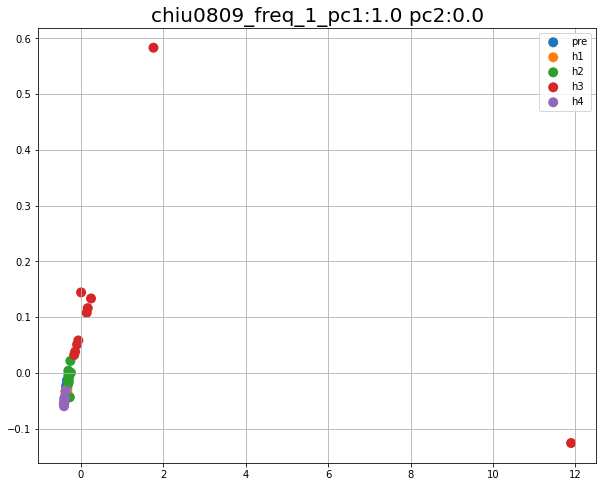

<Figure size 432x288 with 0 Axes>

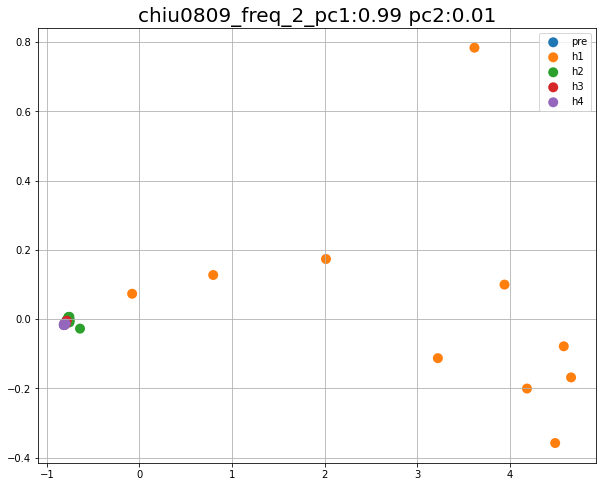

<Figure size 432x288 with 0 Axes>

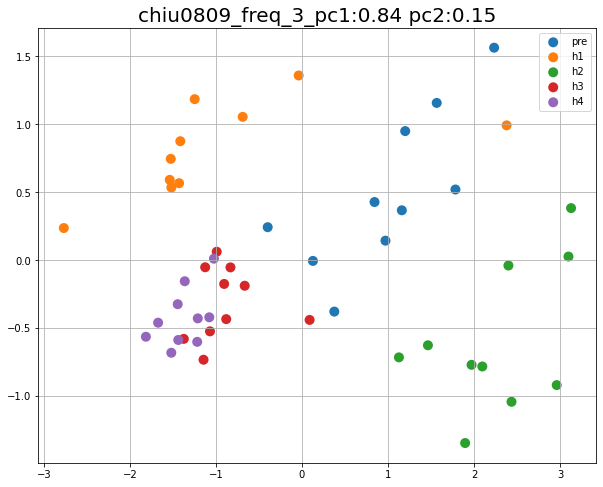

<Figure size 432x288 with 0 Axes>

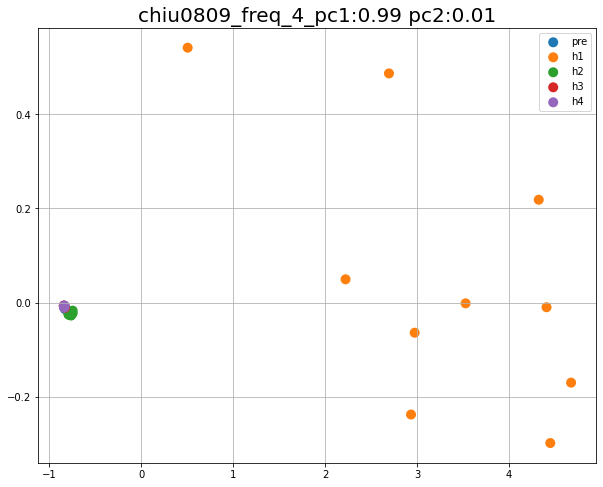

<Figure size 432x288 with 0 Axes>

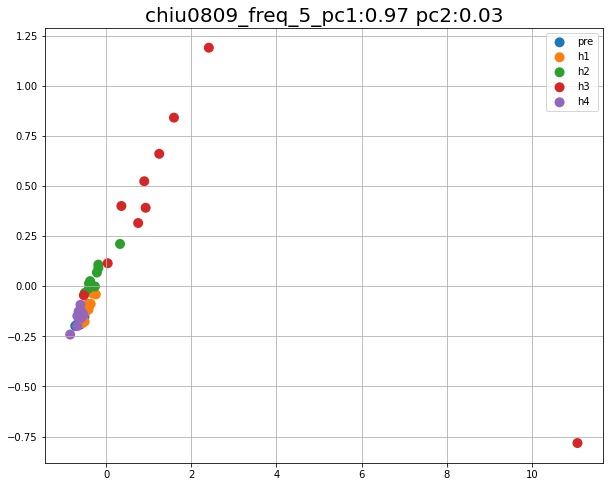

<Figure size 432x288 with 0 Axes>

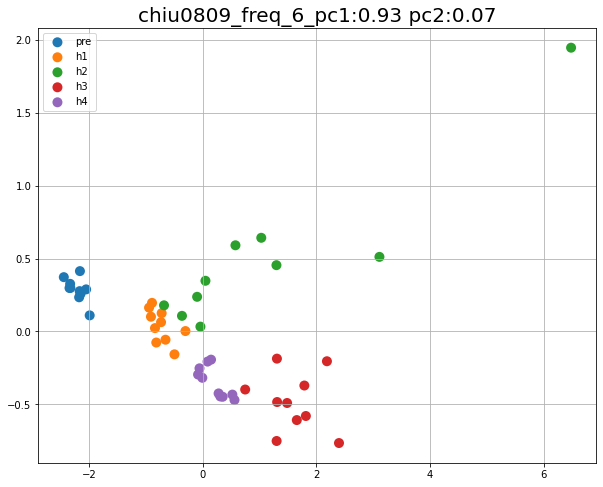

<Figure size 432x288 with 0 Axes>

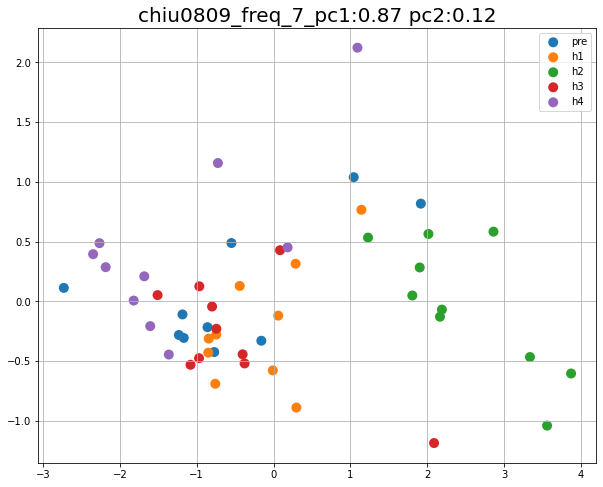

<Figure size 432x288 with 0 Axes>

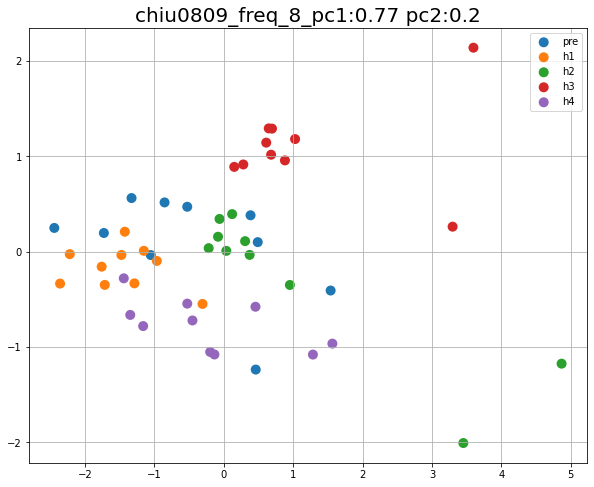

<Figure size 432x288 with 0 Axes>

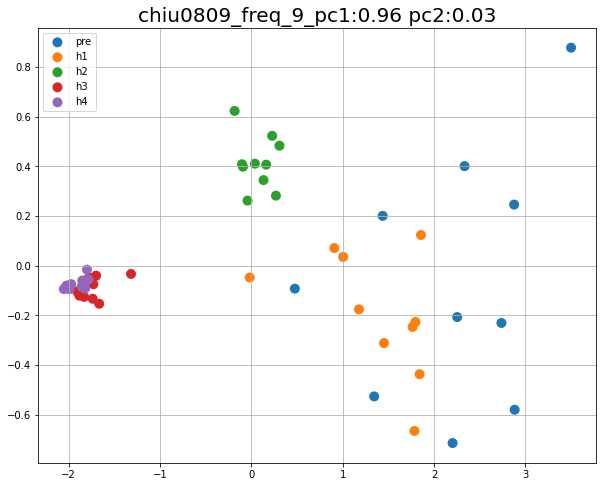

<Figure size 432x288 with 0 Axes>

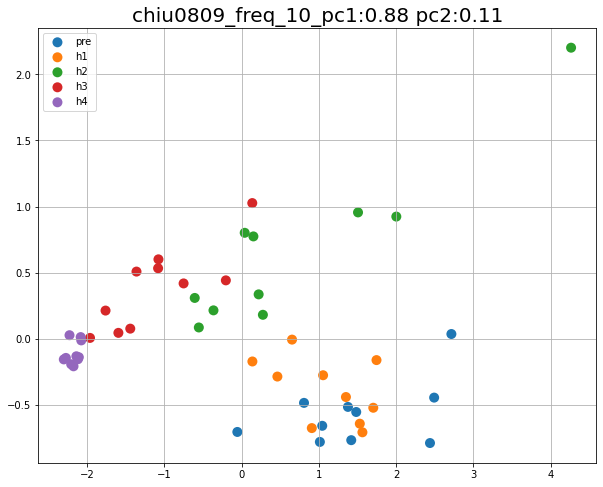

<Figure size 432x288 with 0 Axes>

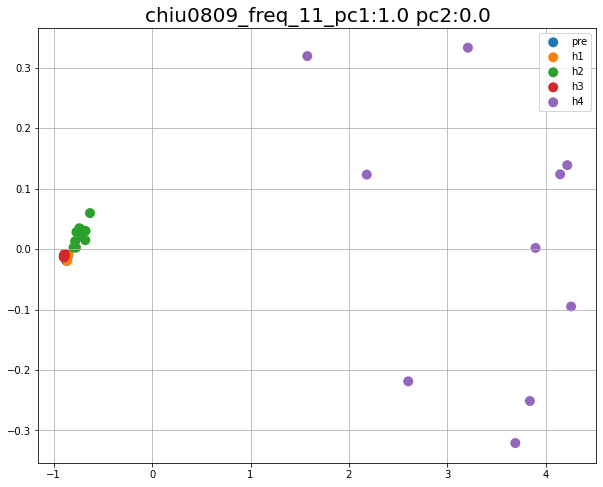

<Figure size 432x288 with 0 Axes>

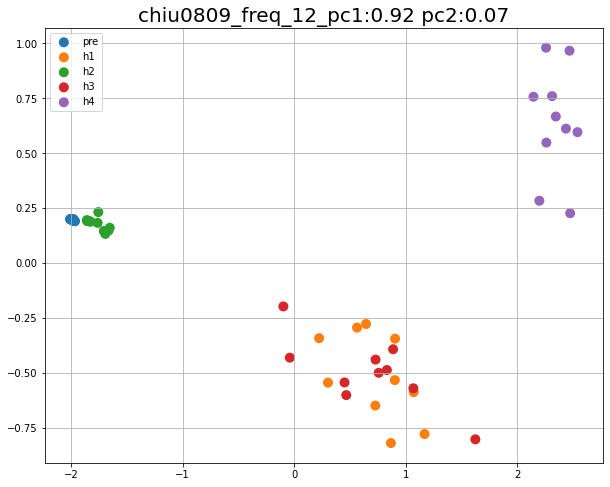

<Figure size 432x288 with 0 Axes>

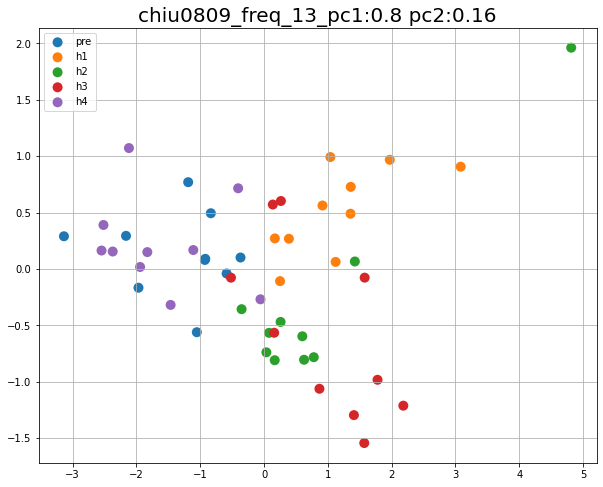

<Figure size 432x288 with 0 Axes>

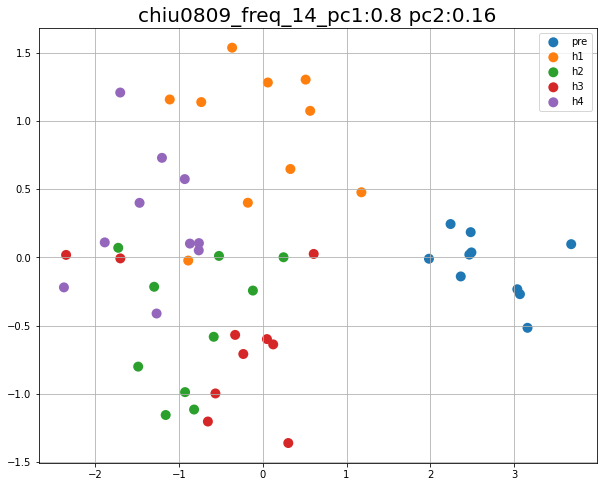

<Figure size 432x288 with 0 Axes>

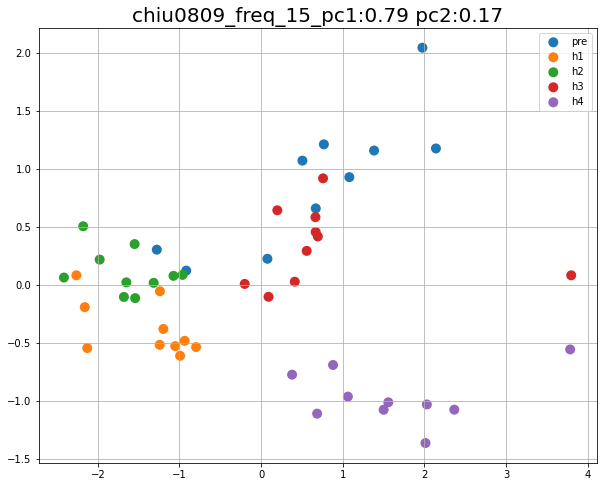

<Figure size 432x288 with 0 Axes>

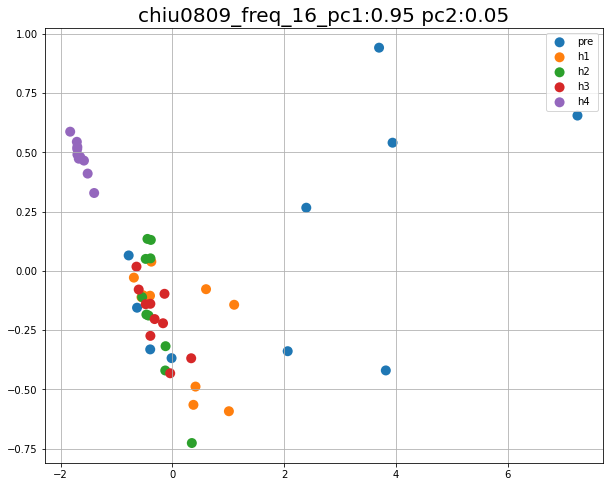

<Figure size 432x288 with 0 Axes>

In [34]:
import seaborn as sns

D=[]
for filename in listdir(mypath): 
    fullpath = join(mypath,filename)
    D.append(getsepDatafreq(fullpath))
for i in range(16):
    Data= pd.DataFrame()    
    for j in range(len(D)):
        Data=pd.concat([Data, D[j][i]], axis=0)   
    # 使用 scikit-learn 內建的 API 正規化
    scaler = StandardScaler()
    Z= scaler.fit_transform(Data)  # 注意維度
    
    # 我們只要最大的兩個主成分。scikit-learn 會自動幫我們
    # 依照 eigenvalue 的大小排序共變異數矩陣的 eigenvectors
    n_components = 2
    random_state = 9527
    pca = PCA(n_components=n_components, 
              random_state=random_state)
    # 注意我們是對正規化後的特徵 Z 做 PCA
    L = pca.fit_transform(Z)  # (n_samples, n_components)

    # 將投影到第一主成分的 repr. 顯示在 x 軸，第二主成分在 y 軸

    fig, ax = plt.subplots(figsize=(10,8))
    for j in range(len(lo)):
        ax.scatter(L[lo[j],0], L[lo[j],1], label=label[j],
                    edgecolors='none',s=100)
    s=np.round(pca.explained_variance_ratio_, 2)

    plt.title(patient+'_freq_'+str(i+1)+'_pc1:'+str(s[0])+' pc2:'+str(s[1]), fontsize =20)
    
    ax.legend()
    ax.grid(True)
    plt.show()
    pcs = np.array(pca.components_) # (n_comp, n_features)

    df_pc = pd.DataFrame(pcs, columns=Data.columns[:])
    df_pc.index = [f"{i+1}cha_{c}_component" for c in['one', 'second']]
    df_pc.style\
        .background_gradient(cmap='bwr_r', axis=None)\
        .format("{:.2}")
    df_pc.to_csv(folder+'_freq_df'+str(i+1)+'.csv')
    fig.savefig(folder+'_freq_pca'+str(i+1)+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
    plt.figure().clear()

# pca 時域指標

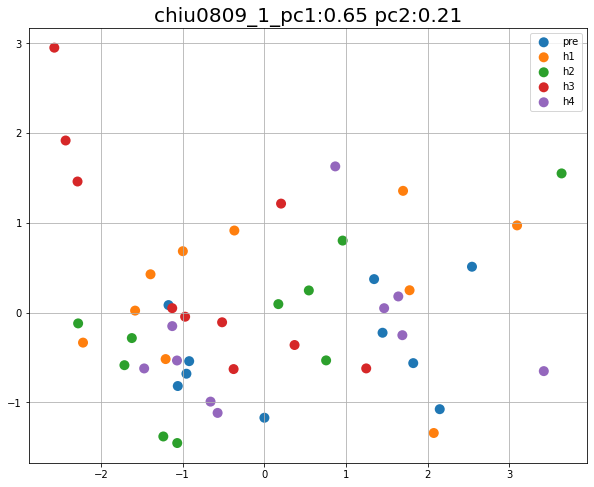

<Figure size 432x288 with 0 Axes>

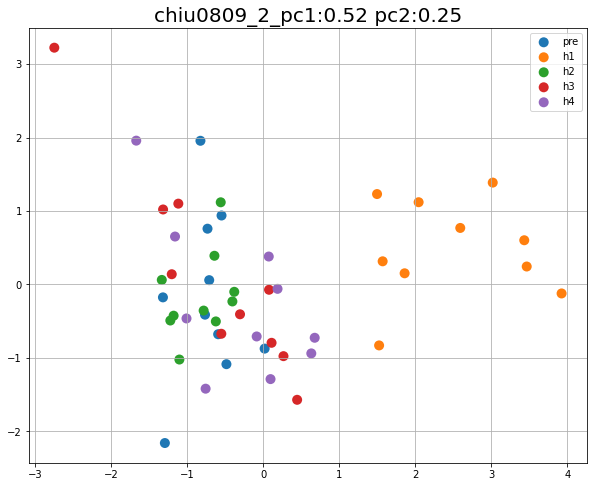

<Figure size 432x288 with 0 Axes>

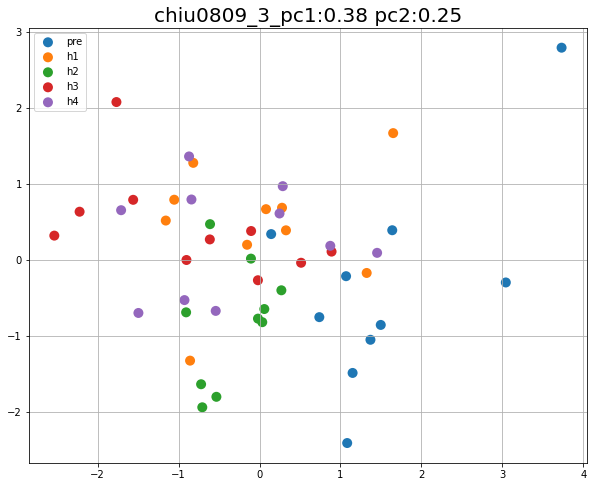

<Figure size 432x288 with 0 Axes>

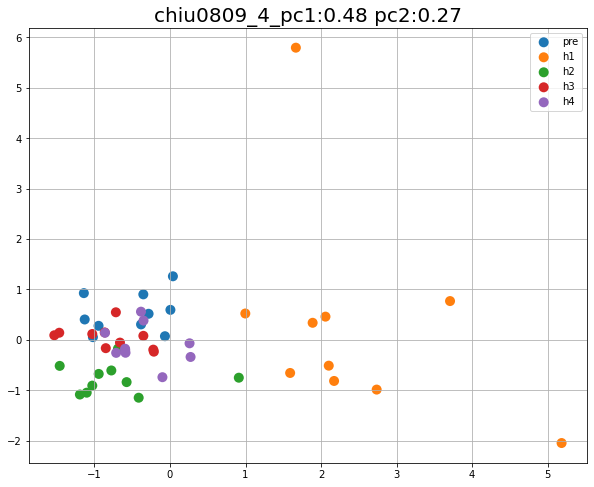

<Figure size 432x288 with 0 Axes>

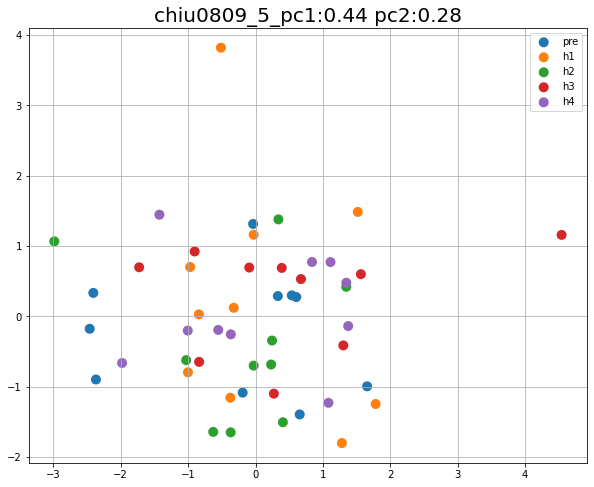

<Figure size 432x288 with 0 Axes>

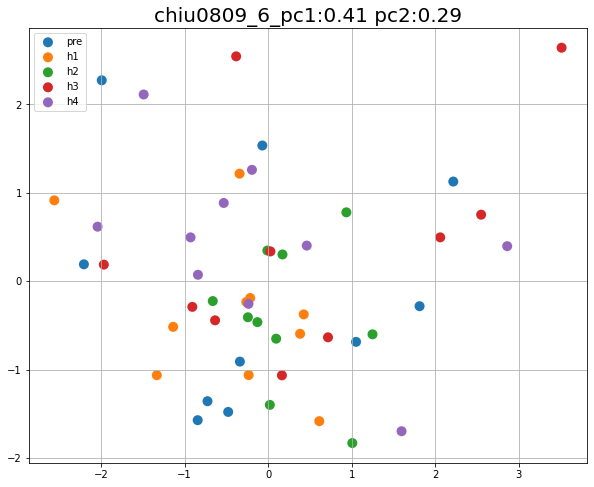

<Figure size 432x288 with 0 Axes>

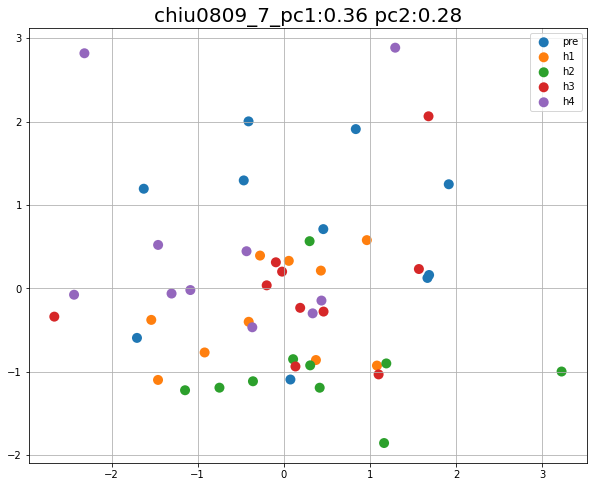

<Figure size 432x288 with 0 Axes>

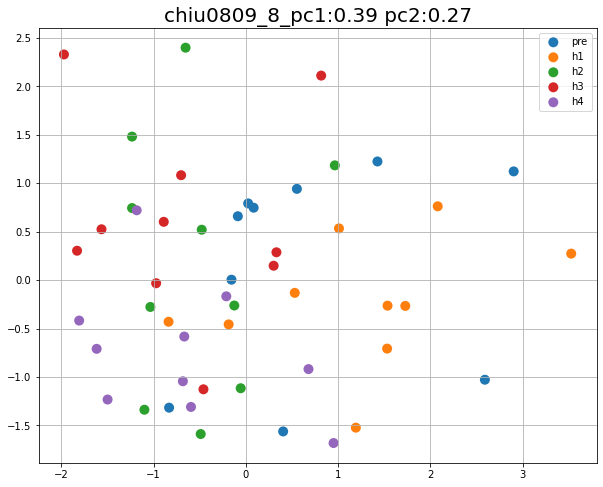

<Figure size 432x288 with 0 Axes>

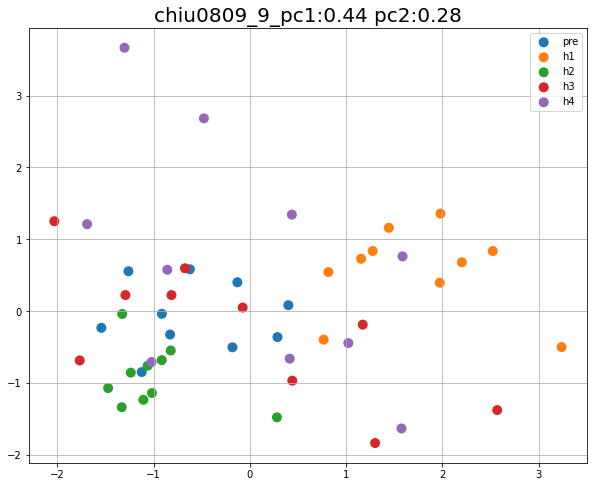

<Figure size 432x288 with 0 Axes>

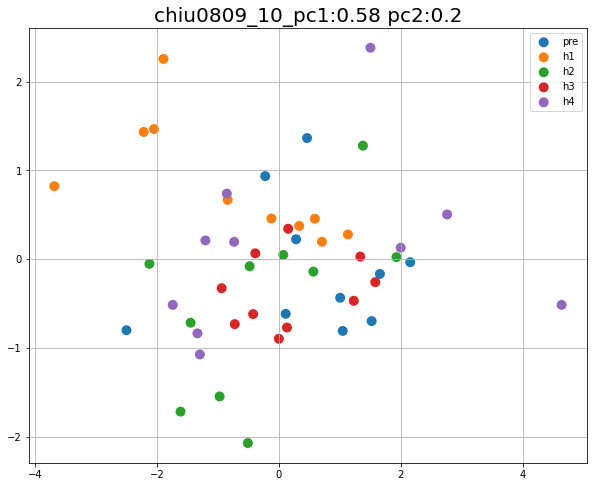

<Figure size 432x288 with 0 Axes>

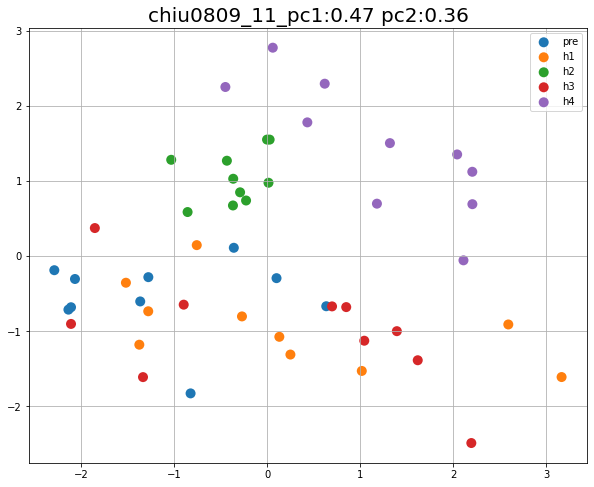

<Figure size 432x288 with 0 Axes>

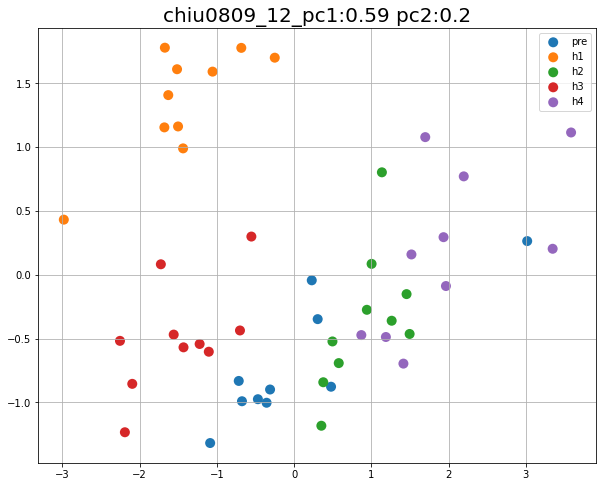

<Figure size 432x288 with 0 Axes>

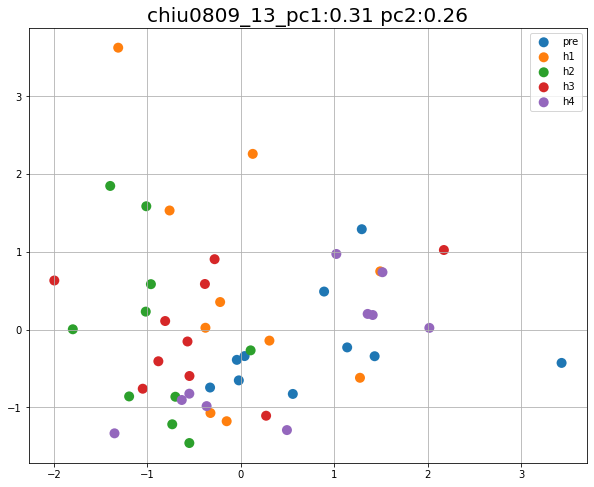

<Figure size 432x288 with 0 Axes>

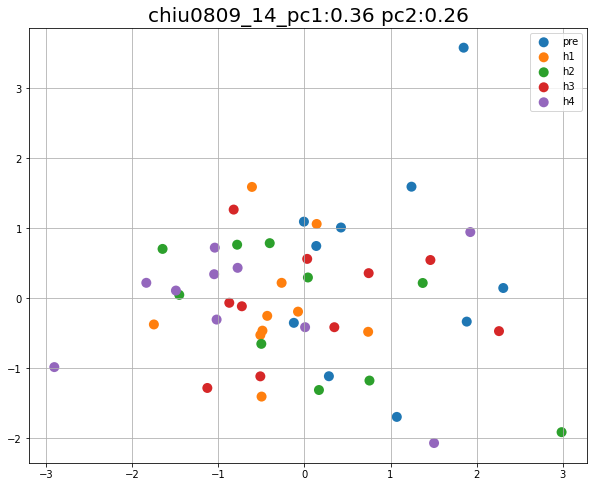

<Figure size 432x288 with 0 Axes>

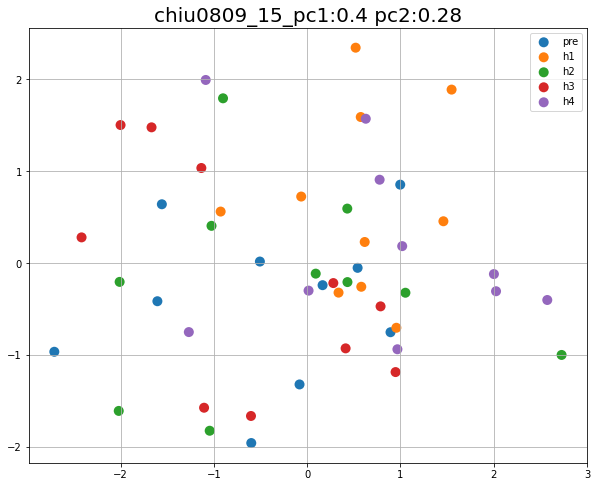

<Figure size 432x288 with 0 Axes>

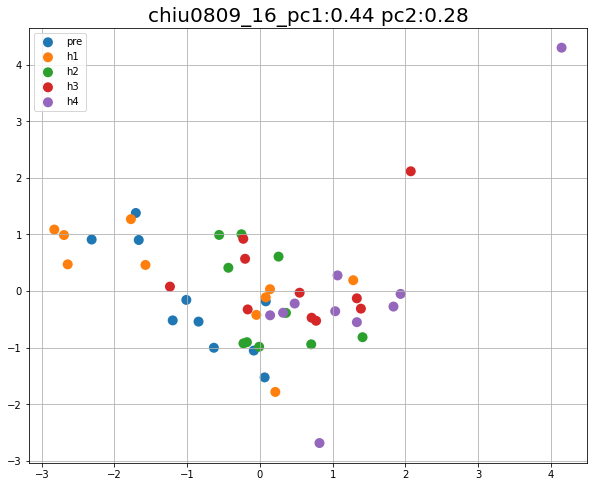

<Figure size 432x288 with 0 Axes>

In [35]:
import seaborn as sns
D=[]
for filename in listdir(mypath): 
    fullpath = join(mypath,filename)
    D.append(getsepDatatime(fullpath))
for i in range(16):
    Data= pd.DataFrame()    
    for j in range(len(D)):
        Data=pd.concat([Data, D[j][i]], axis=0)   
        # 使用 scikit-learn 內建的 API 正規化
    scaler = StandardScaler()
    Z= scaler.fit_transform(Data)  # 注意維度
    
    # 我們只要最大的兩個主成分。scikit-learn 會自動幫我們
    # 依照 eigenvalue 的大小排序共變異數矩陣的 eigenvectors
    n_components = 2
    random_state = 9527
    pca = PCA(n_components=n_components, 
              random_state=random_state)
    # 注意我們是對正規化後的特徵 Z 做 PCA
    L = pca.fit_transform(Z)  # (n_samples, n_components)

    # 將投影到第一主成分的 repr. 顯示在 x 軸，第二主成分在 y 軸
    fig, ax = plt.subplots(figsize=(10,8))

    for j in range(len(lo)):
        ax.scatter(L[lo[j],0], L[lo[j],1],  label=label[j],
                    edgecolors='none',s=100)
    s=np.round(pca.explained_variance_ratio_, 2)

    plt.title(patient+'_'+str(i+1)+'_pc1:'+str(s[0])+' pc2:'+str(s[1]), fontsize =20)
    
    ax.legend()
    ax.grid(True)
    plt.show()
    pcs = np.array(pca.components_) # (n_comp, n_features)

    df_pc = pd.DataFrame(pcs, columns=Data.columns[:])
    df_pc.index = [f"{i+1}cha_{c}_component" for c in['one', 'second']]
    df_pc.style\
        .background_gradient(cmap='bwr_r', axis=None)\
        .format("{:.2}")
    df_pc.to_csv(folder+'_time_df'+str(i+1)+'.csv')
    fig.savefig(folder+'_time_pca'+str(i+1)+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
    plt.figure().clear()

# 將多個csv檔案合併成一個檔案

In [36]:
import csv
from pathlib import Path
# 讀入檔案
rows =[]
# 最初讀入時，header也要讀入
for file in Path(patient).glob("*.csv"):
    if(file==(folder+patient+'_df.csv')):
        continue
    f = open(file)
    reader = csv.reader(f)
    for row in reader:
        rows.append(row)
    rows.append([''])
    f.close()
for folder, subfolders, files in os.walk(patient+'/'):        
    for file in files:        
        # checking if file is 
        # of .csv type 
        if file.endswith('.csv'): 
            path = os.path.join(folder, file) 
                
            # deleting the csv file 
            os.remove(path)
# 寫入檔案
f = open(folder+patient+'_df.csv',mode='w', newline="")
writer = csv.writer(f)
for row in rows:
    writer.writerow(row)
f.close()

# barchart

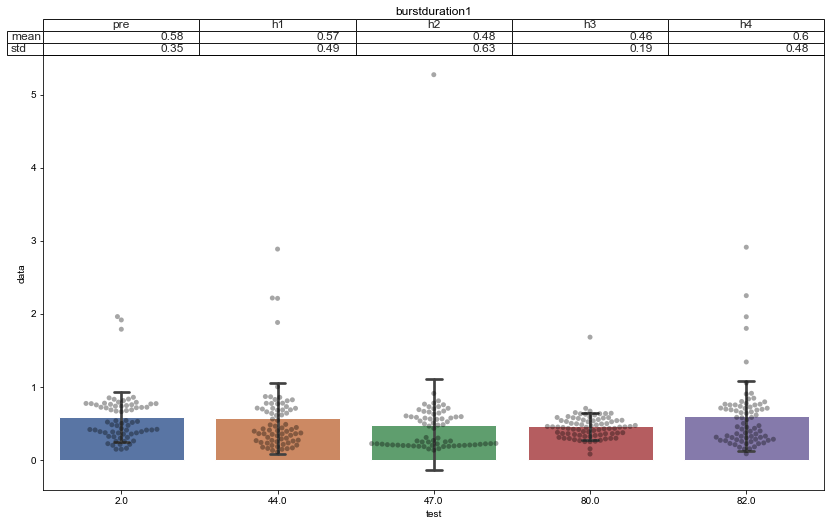

<Figure size 432x288 with 0 Axes>

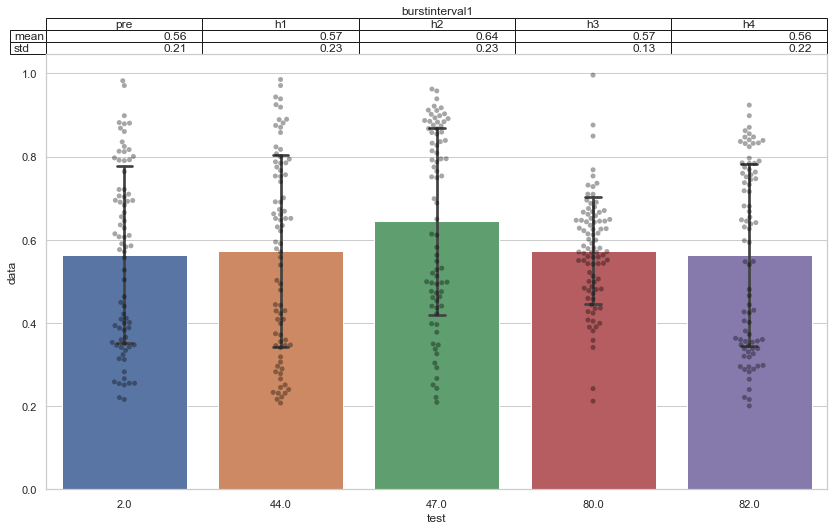

<Figure size 432x288 with 0 Axes>

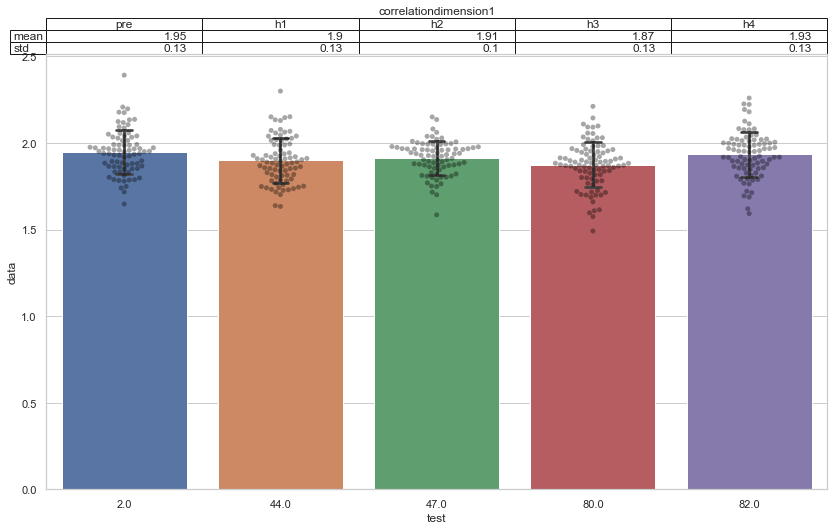

<Figure size 432x288 with 0 Axes>

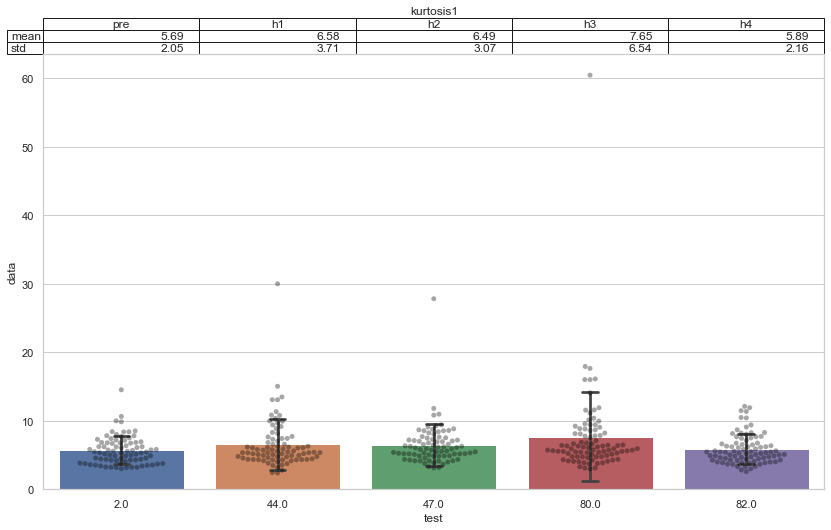

<Figure size 432x288 with 0 Axes>

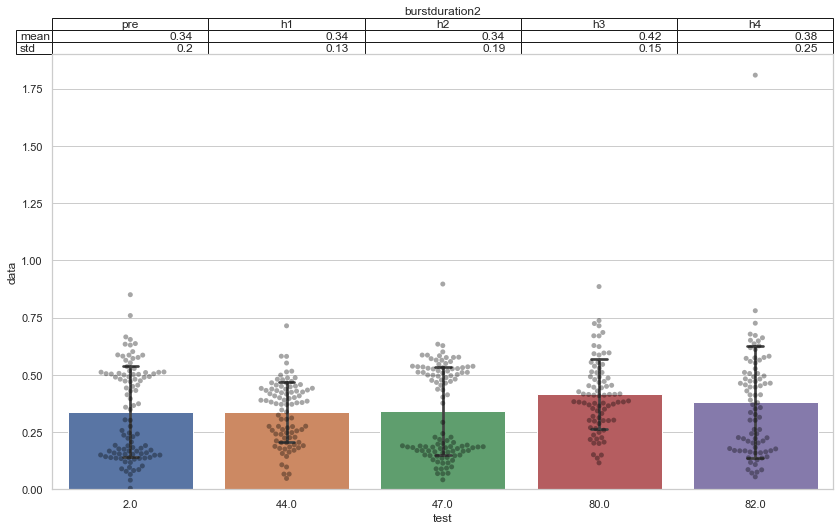

<Figure size 432x288 with 0 Axes>

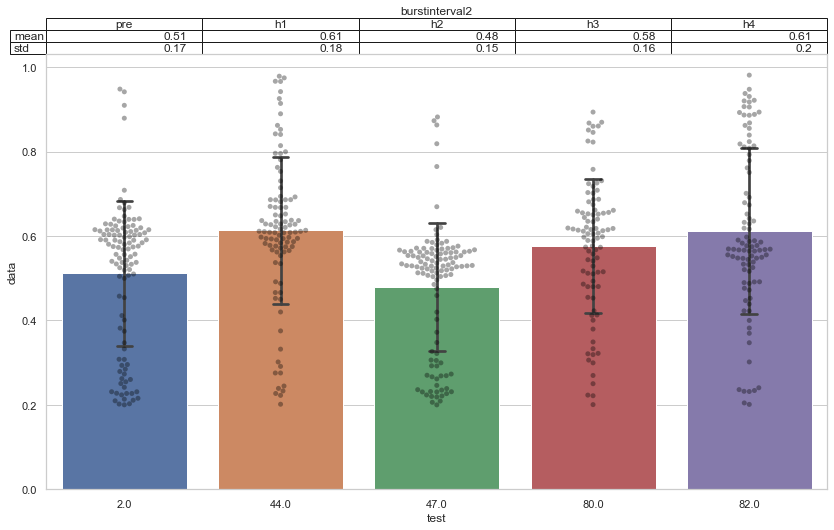

<Figure size 432x288 with 0 Axes>

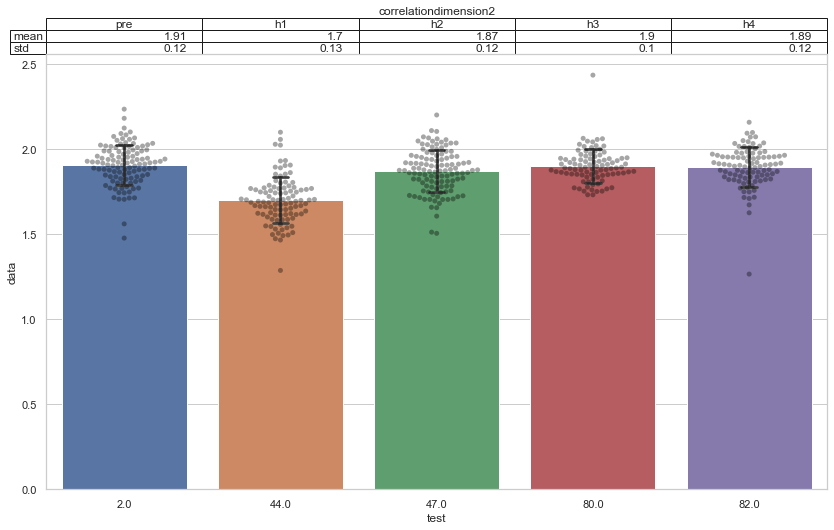

<Figure size 432x288 with 0 Axes>

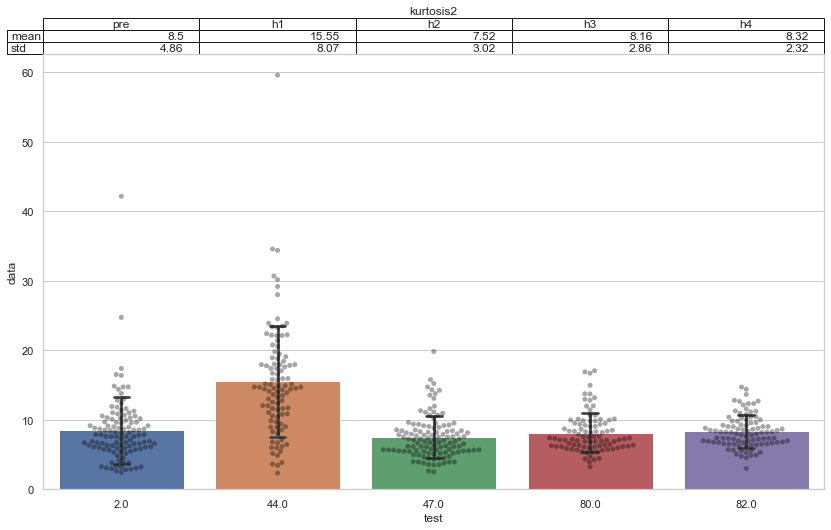

<Figure size 432x288 with 0 Axes>

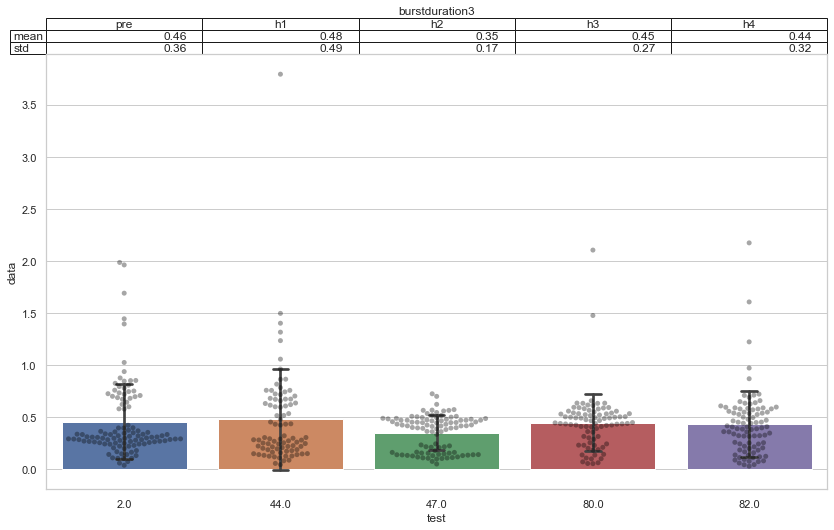

<Figure size 432x288 with 0 Axes>

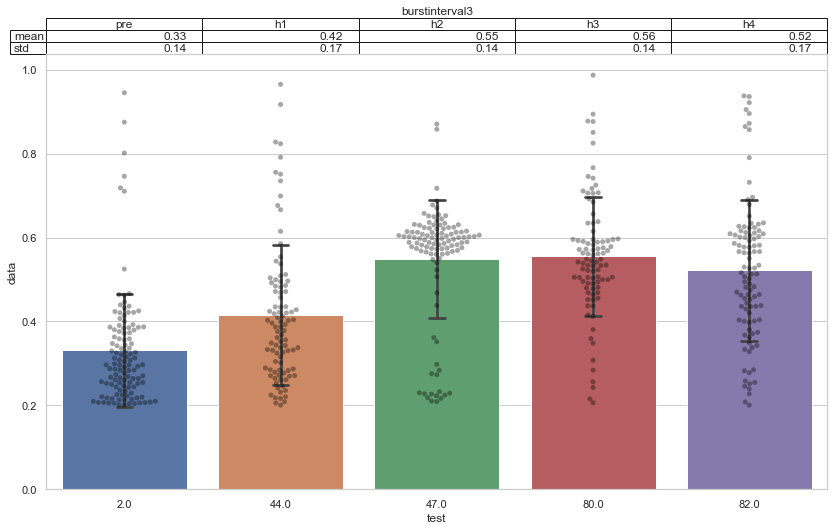

<Figure size 432x288 with 0 Axes>

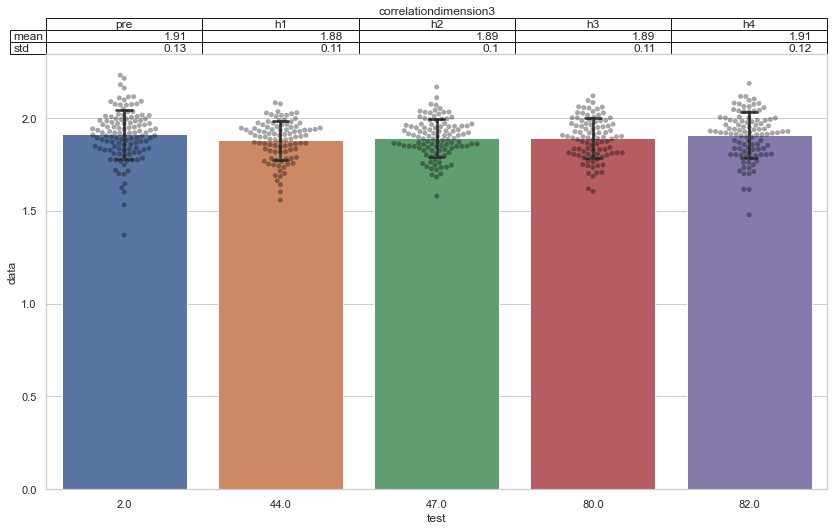

<Figure size 432x288 with 0 Axes>

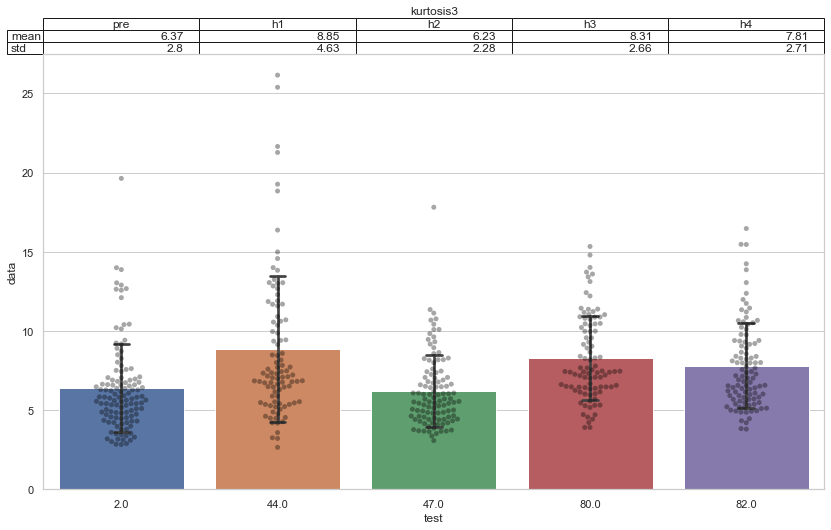

<Figure size 432x288 with 0 Axes>

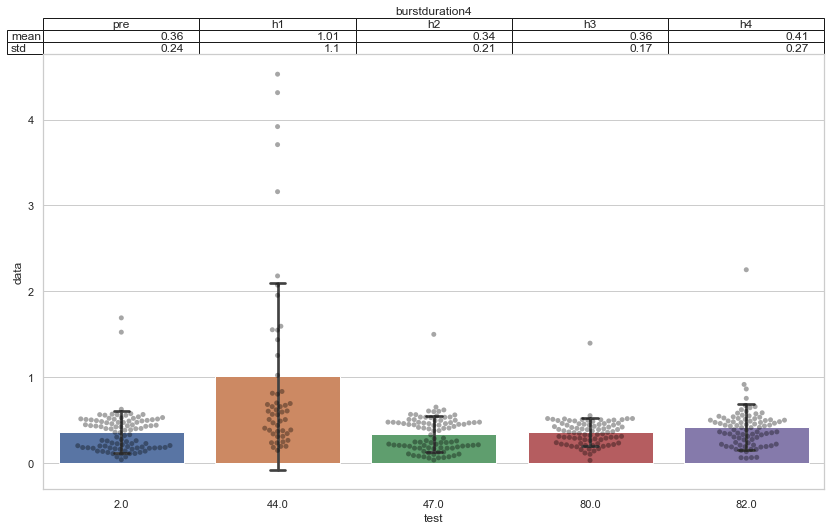

<Figure size 432x288 with 0 Axes>

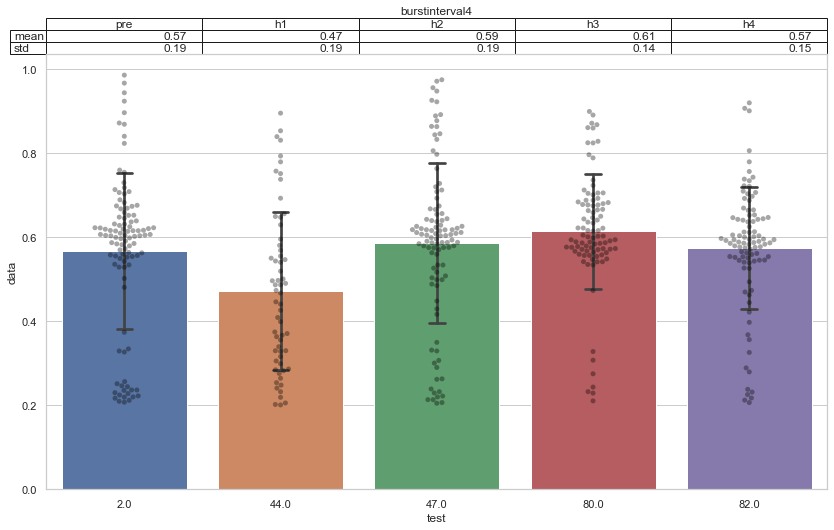

<Figure size 432x288 with 0 Axes>

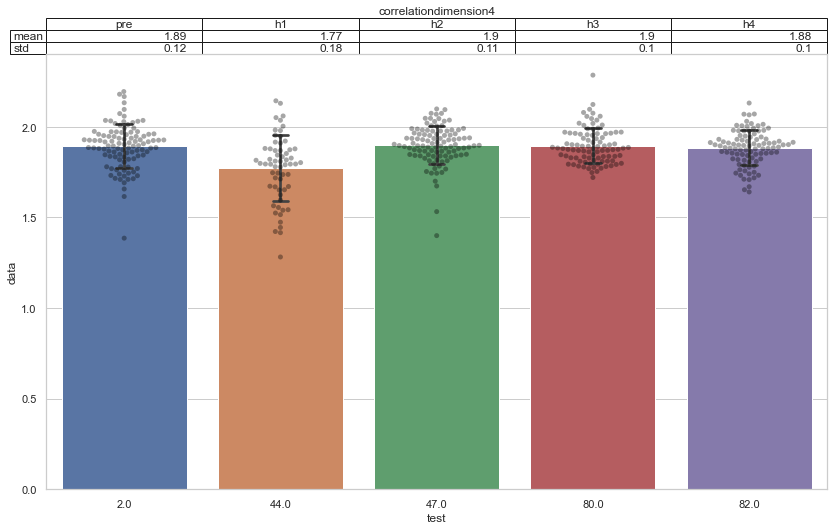

<Figure size 432x288 with 0 Axes>

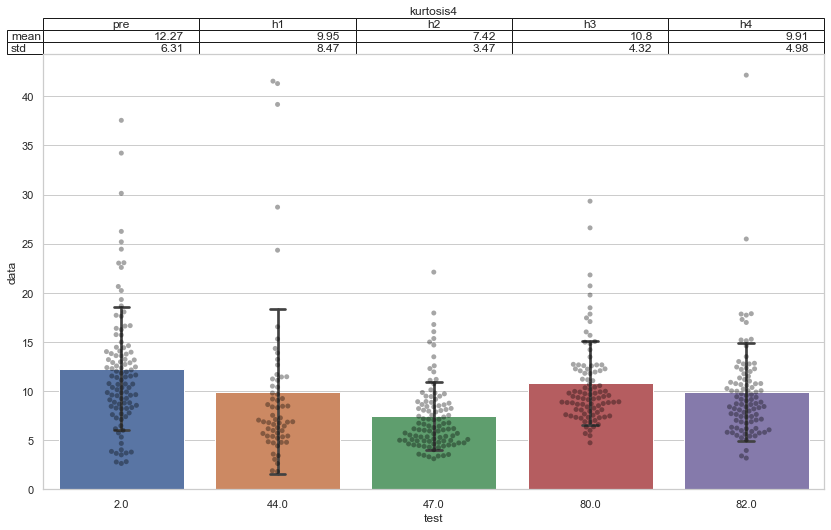

<Figure size 432x288 with 0 Axes>

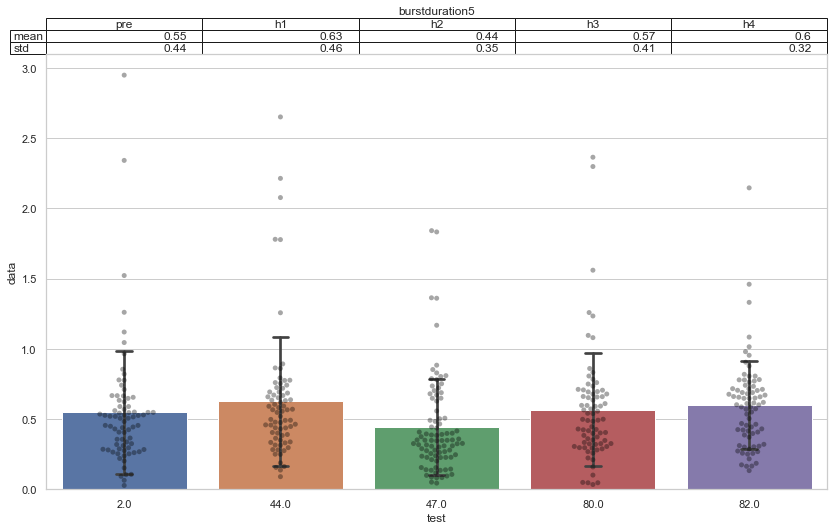

<Figure size 432x288 with 0 Axes>

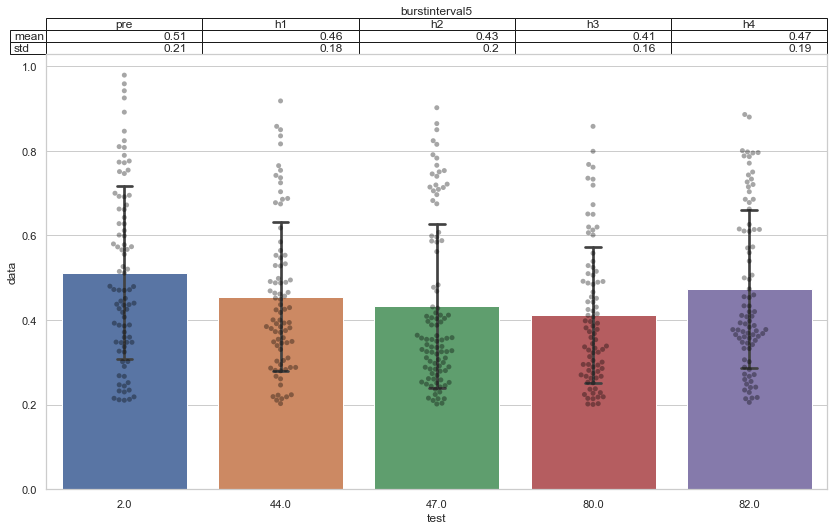

<Figure size 432x288 with 0 Axes>

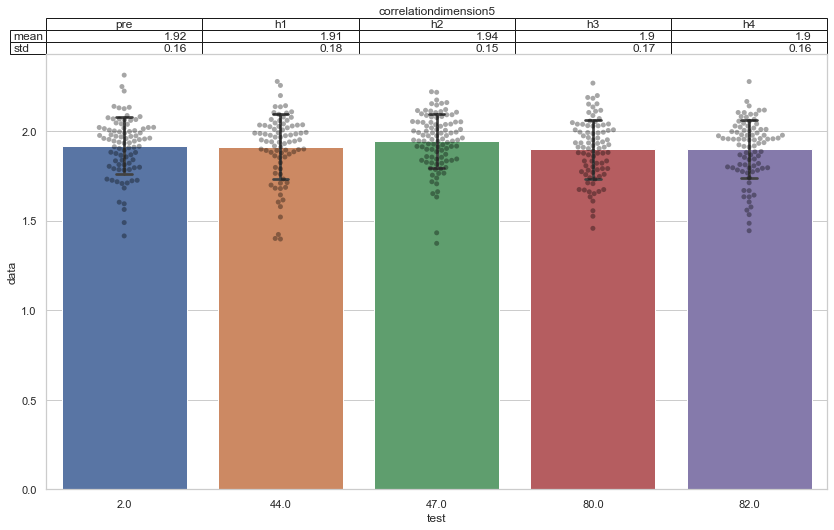

<Figure size 432x288 with 0 Axes>

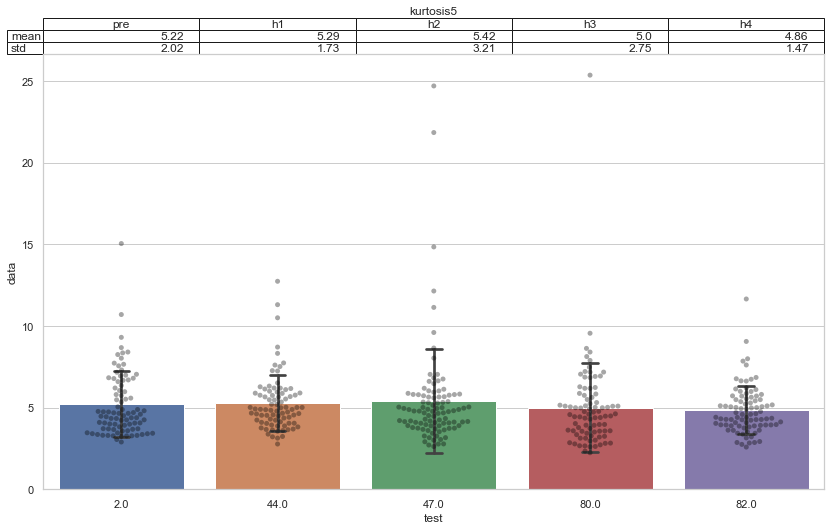

<Figure size 432x288 with 0 Axes>

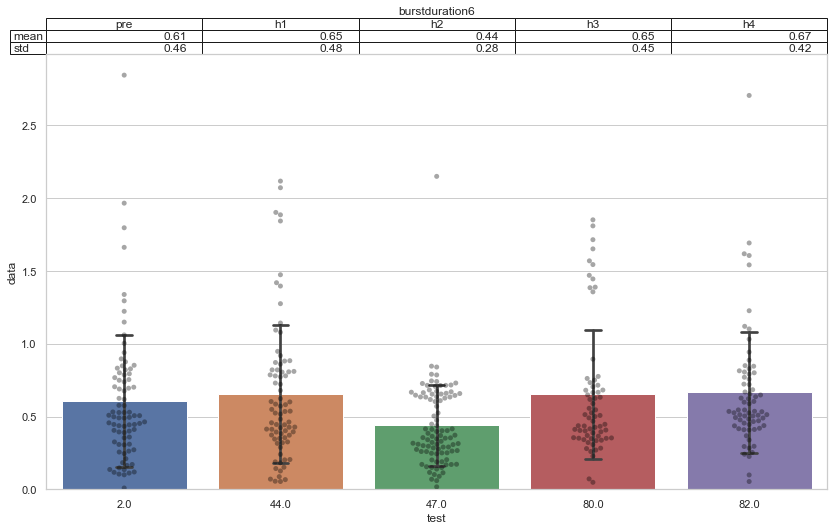

<Figure size 432x288 with 0 Axes>

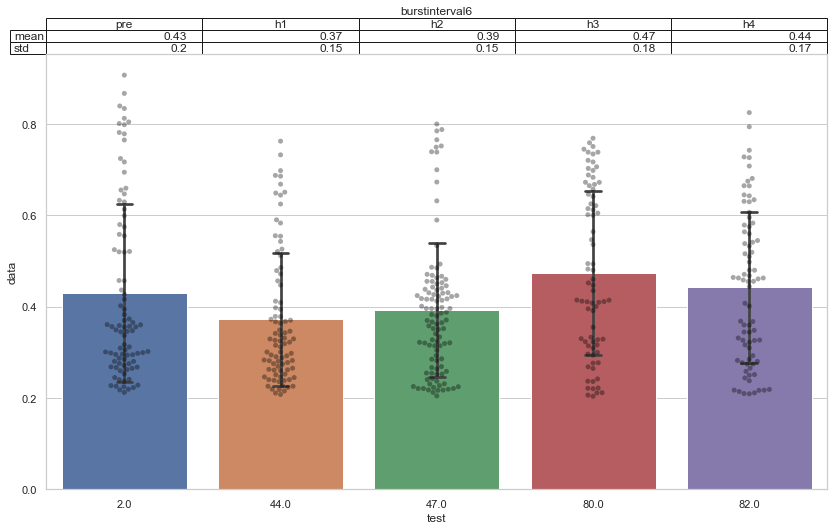

<Figure size 432x288 with 0 Axes>

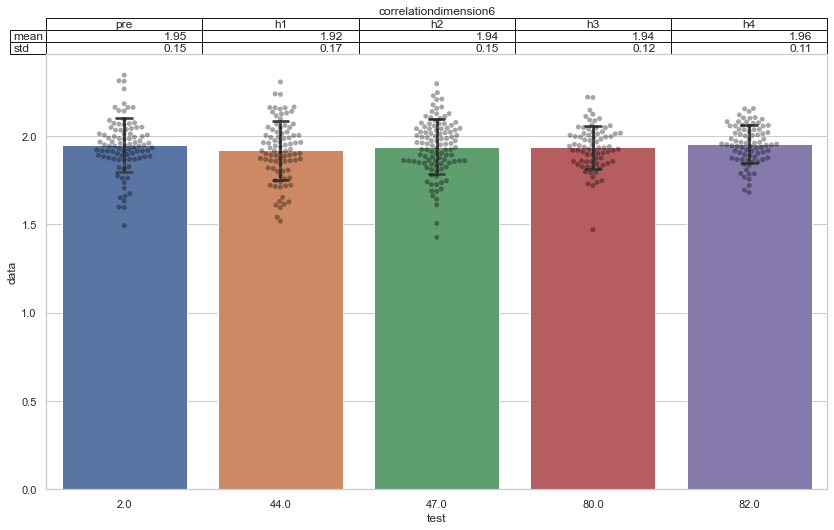

<Figure size 432x288 with 0 Axes>

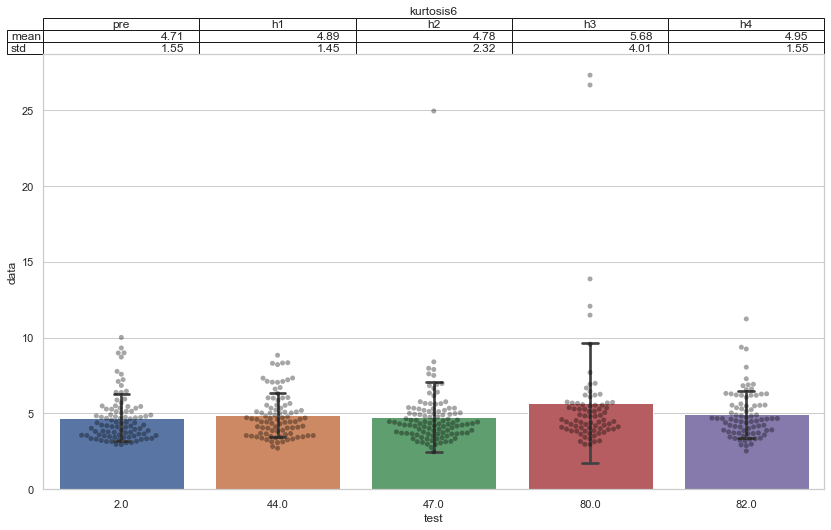

<Figure size 432x288 with 0 Axes>

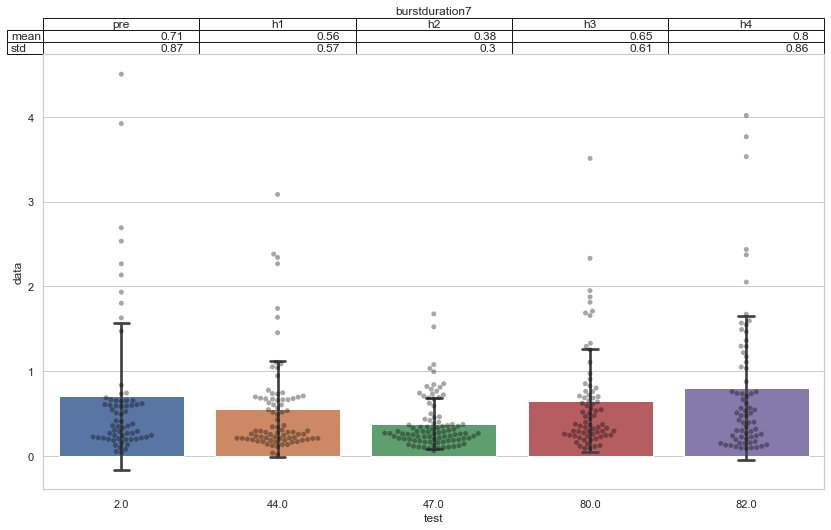

<Figure size 432x288 with 0 Axes>

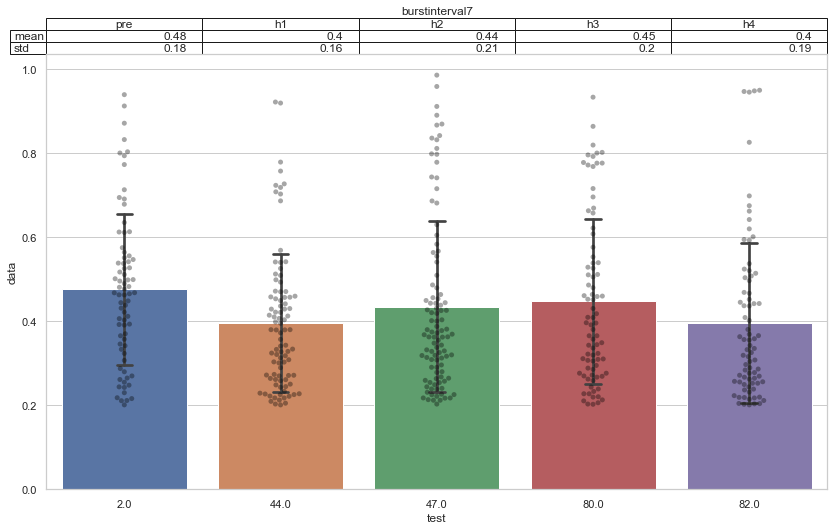

<Figure size 432x288 with 0 Axes>

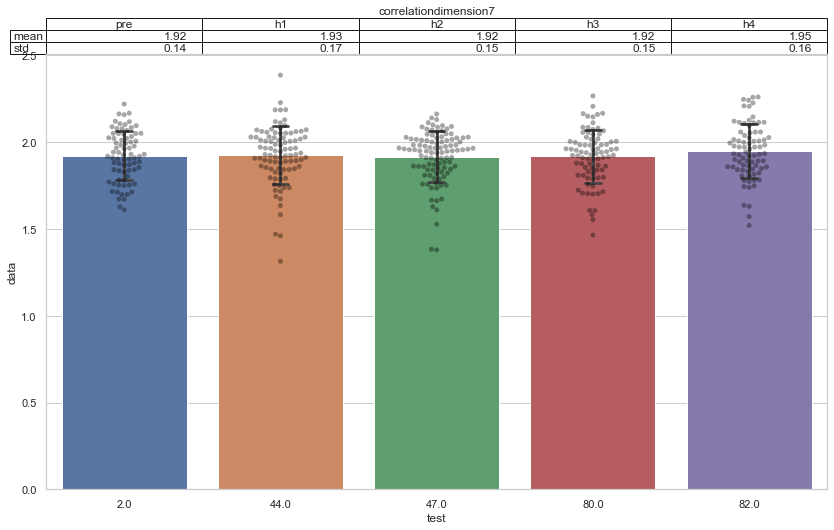

<Figure size 432x288 with 0 Axes>

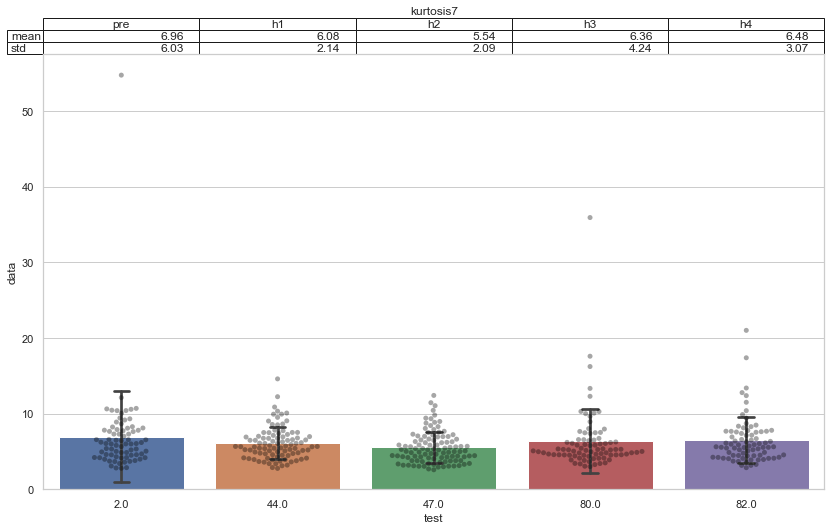

<Figure size 432x288 with 0 Axes>

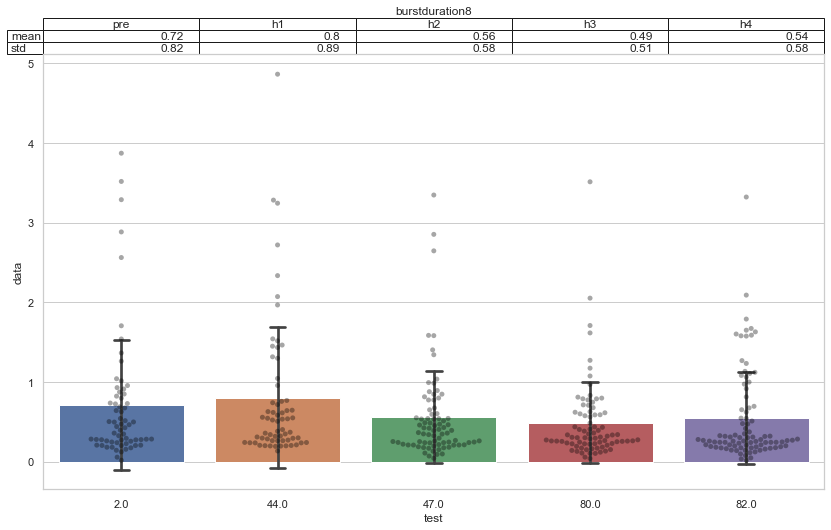

<Figure size 432x288 with 0 Axes>

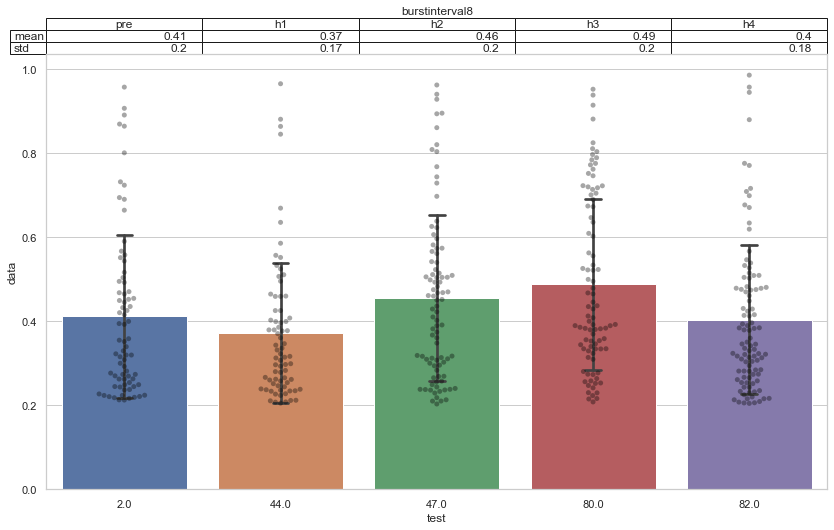

<Figure size 432x288 with 0 Axes>

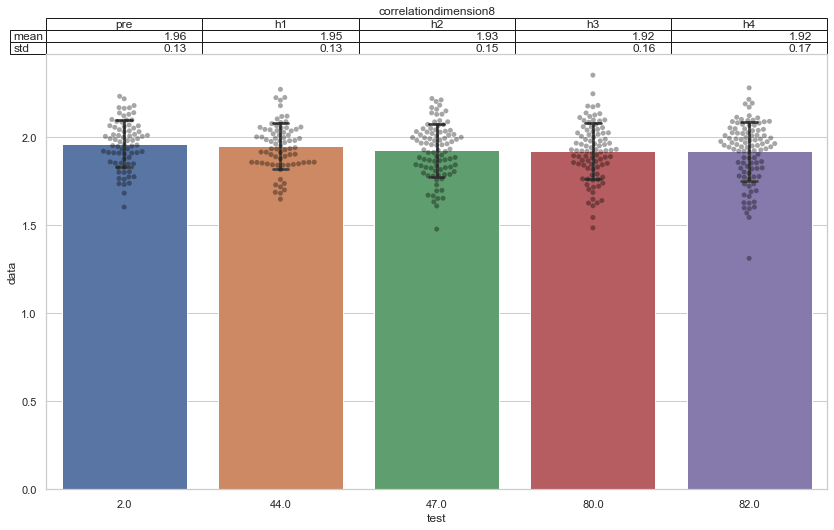

<Figure size 432x288 with 0 Axes>

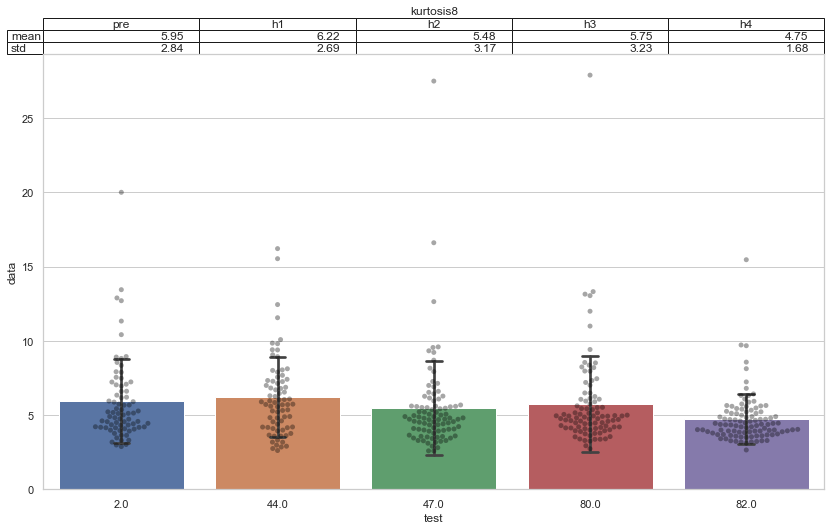

C:\Users\huang\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

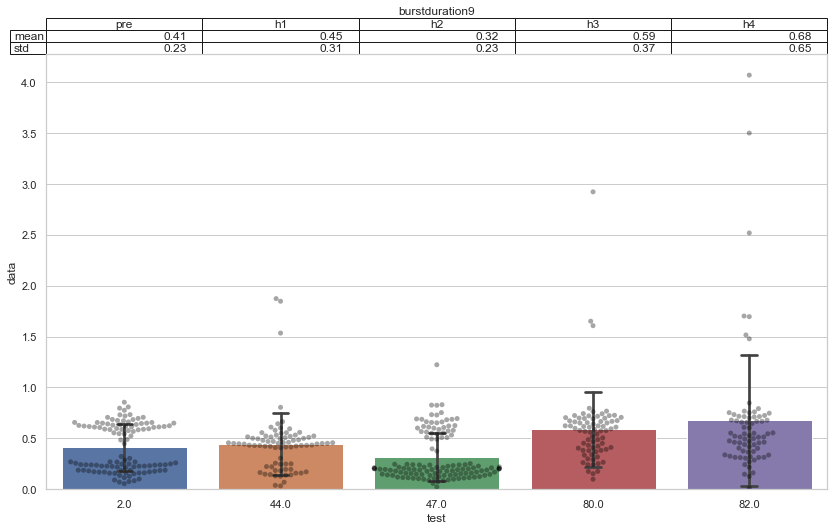

<Figure size 432x288 with 0 Axes>

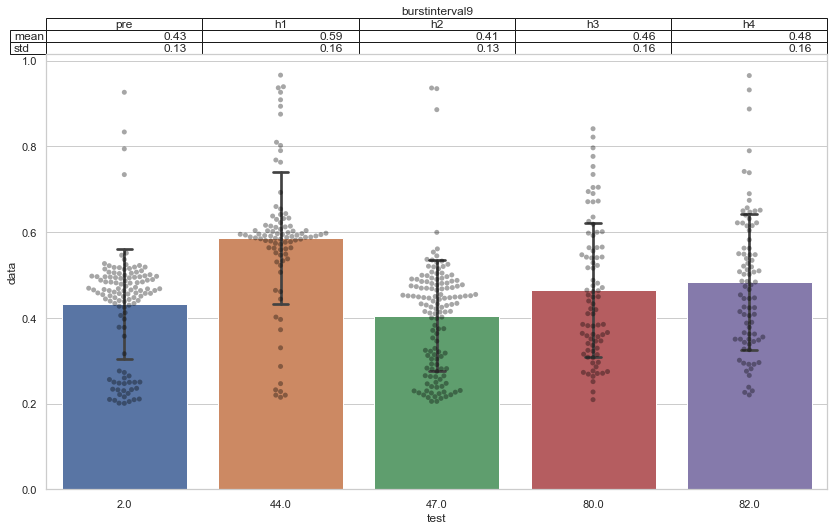

<Figure size 432x288 with 0 Axes>

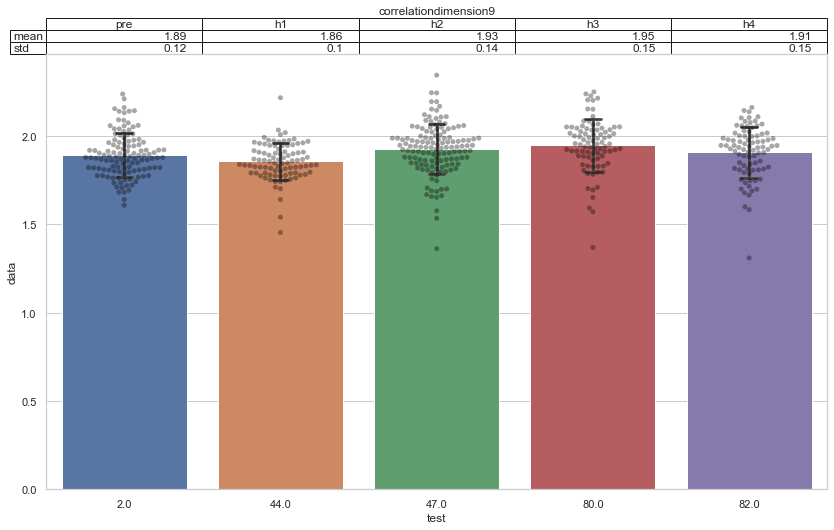

<Figure size 432x288 with 0 Axes>

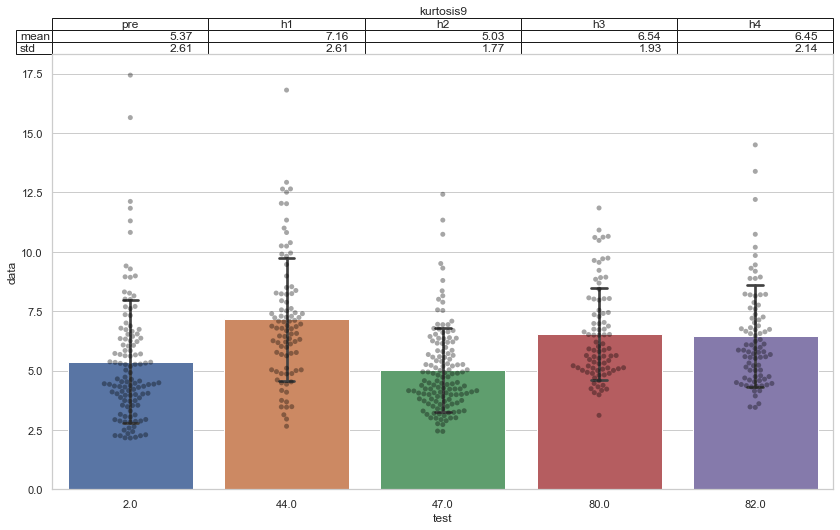

<Figure size 432x288 with 0 Axes>

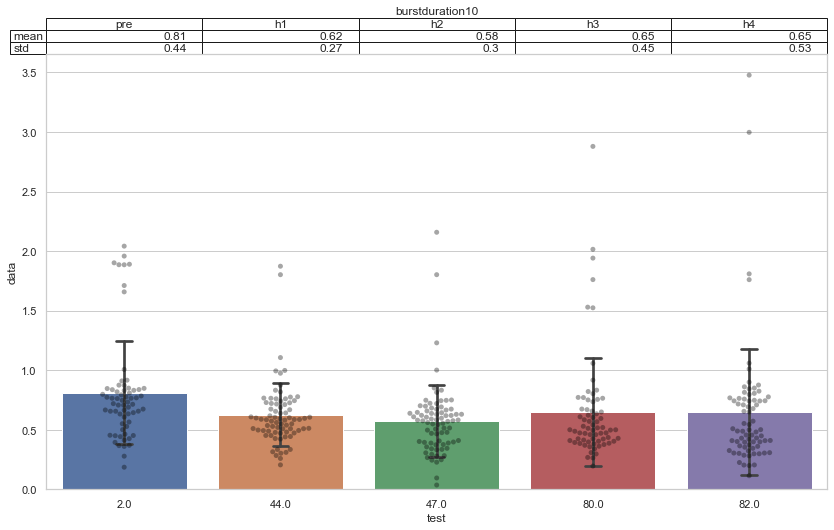

<Figure size 432x288 with 0 Axes>

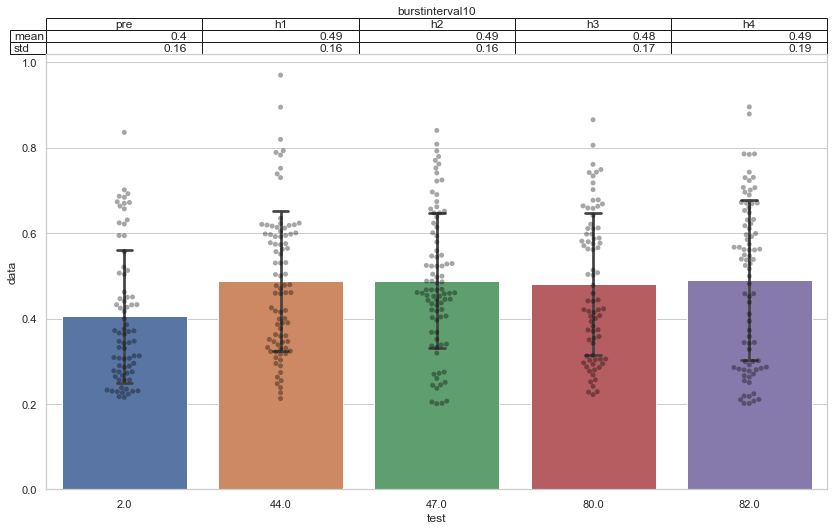

<Figure size 432x288 with 0 Axes>

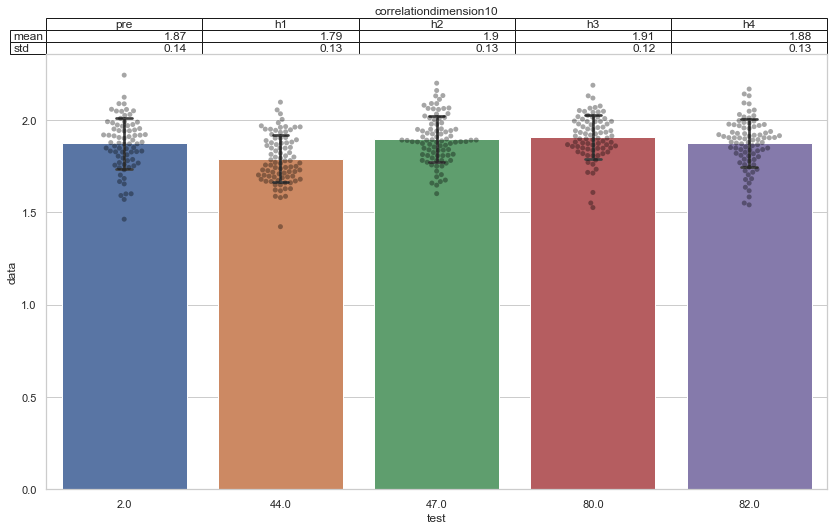

<Figure size 432x288 with 0 Axes>

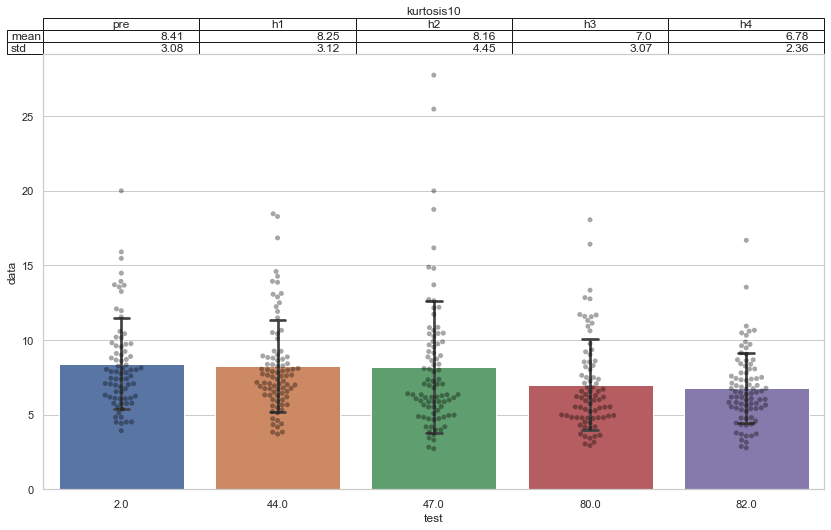

<Figure size 432x288 with 0 Axes>

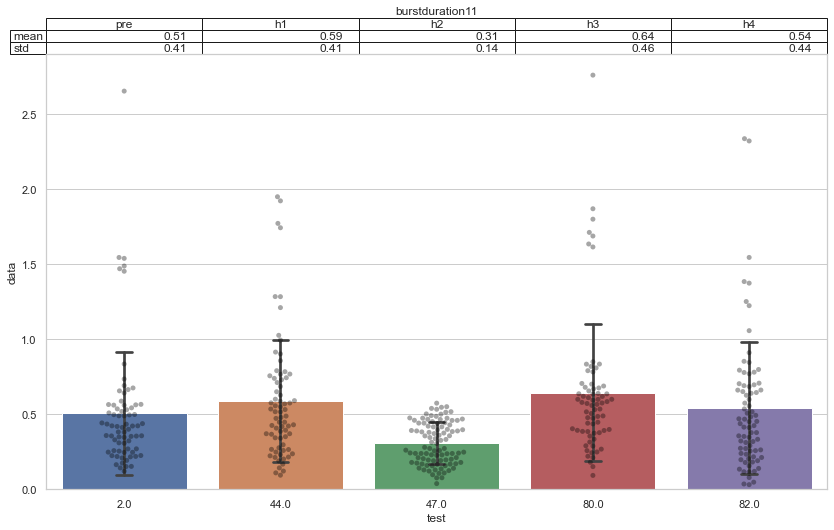

<Figure size 432x288 with 0 Axes>

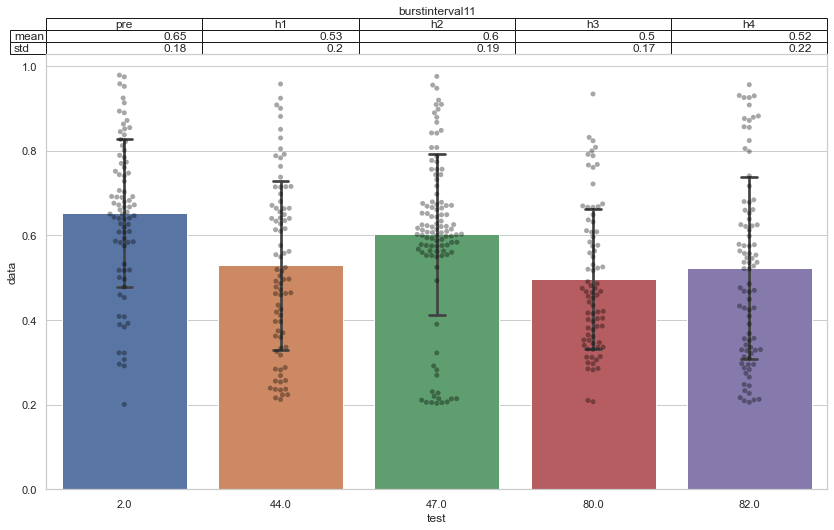

<Figure size 432x288 with 0 Axes>

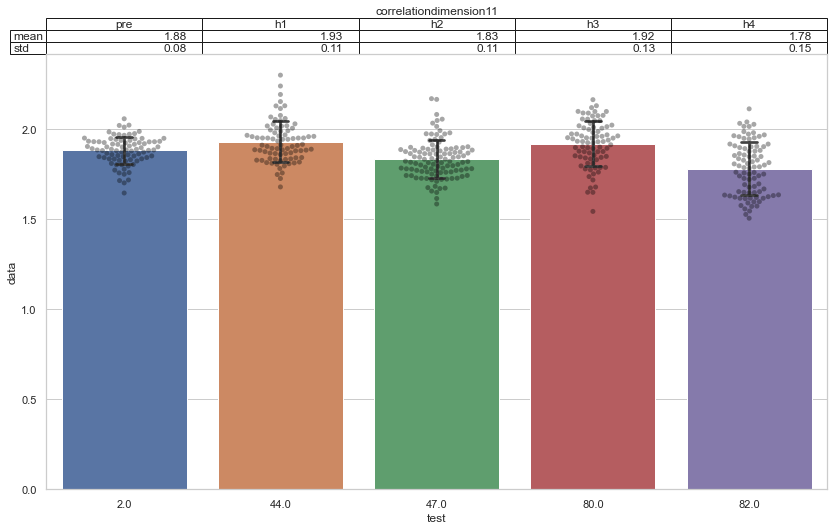

<Figure size 432x288 with 0 Axes>

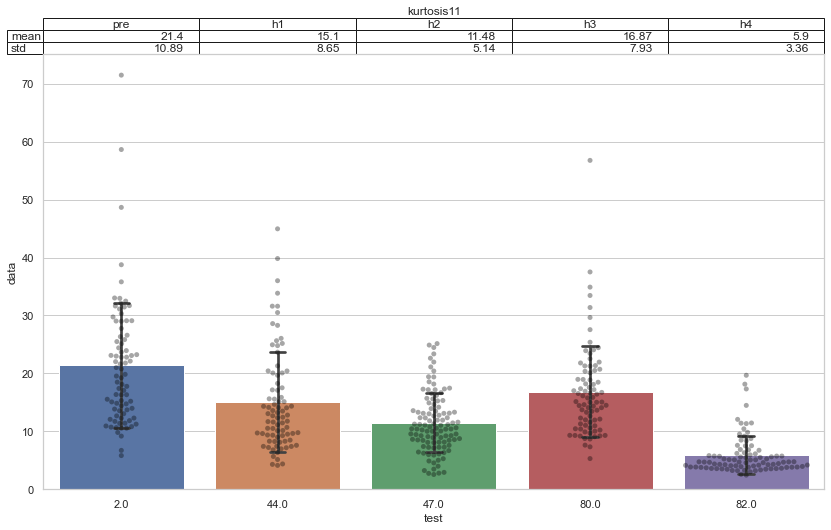

<Figure size 432x288 with 0 Axes>

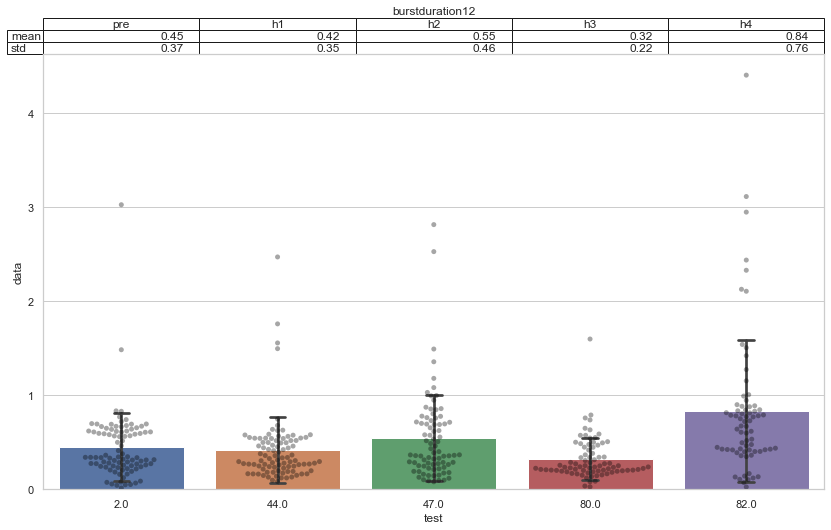

<Figure size 432x288 with 0 Axes>

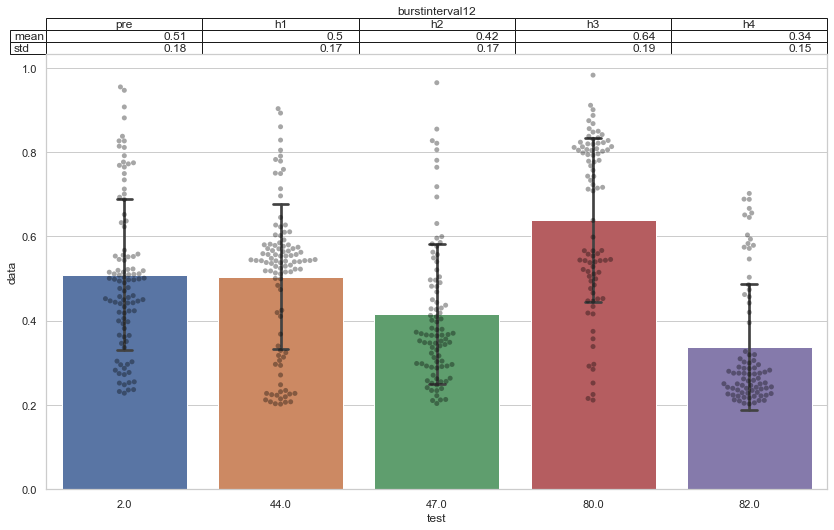

<Figure size 432x288 with 0 Axes>

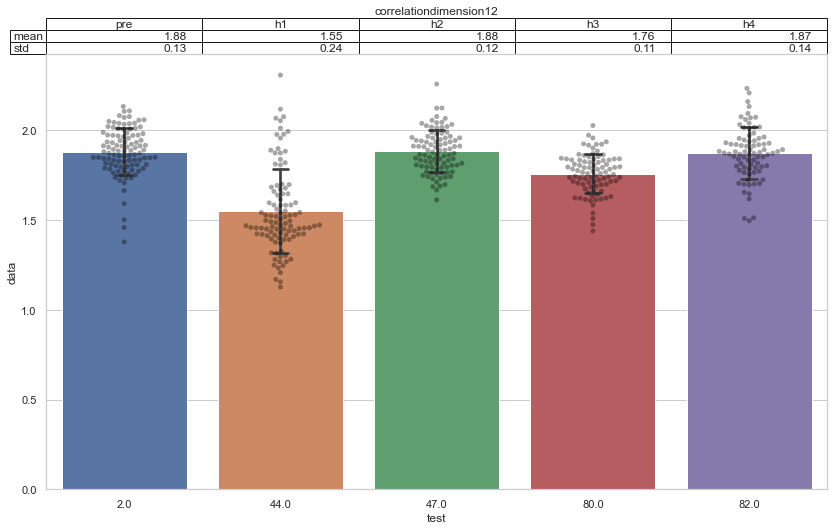

C:\Users\huang\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\huang\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

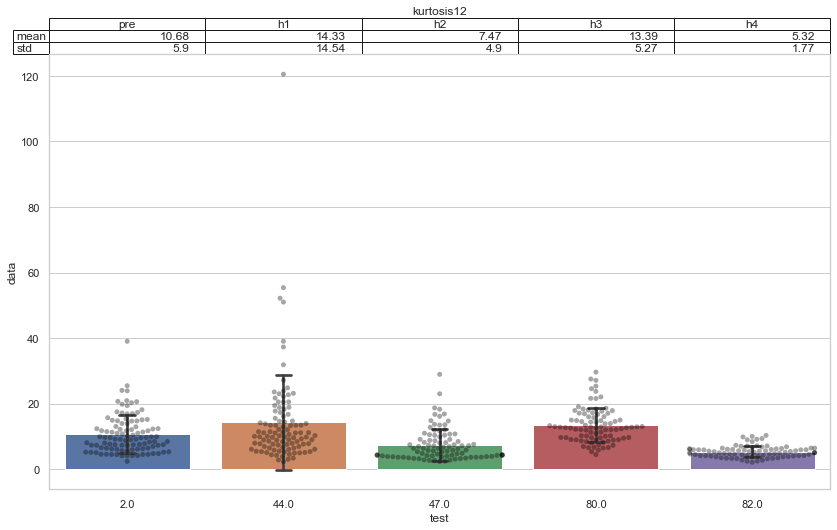

<Figure size 432x288 with 0 Axes>

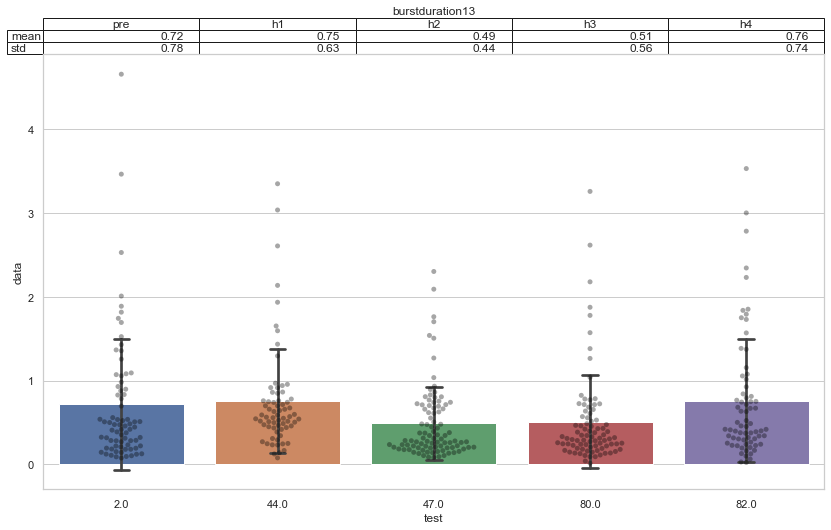

<Figure size 432x288 with 0 Axes>

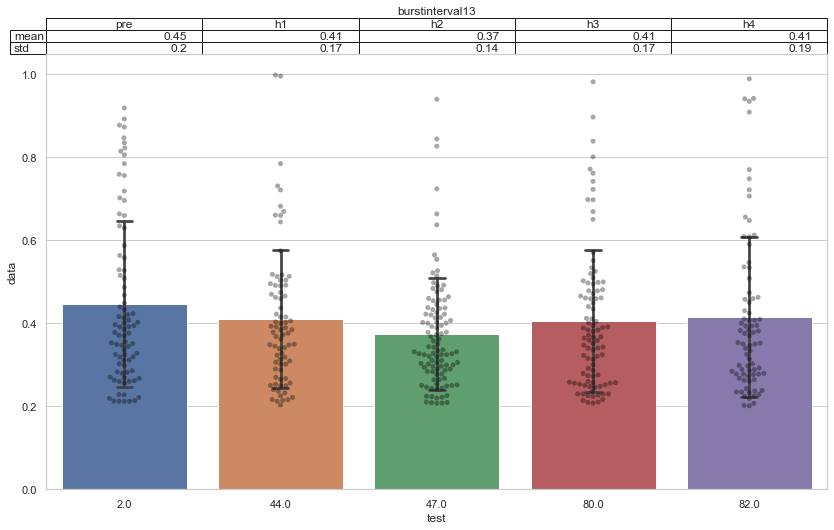

<Figure size 432x288 with 0 Axes>

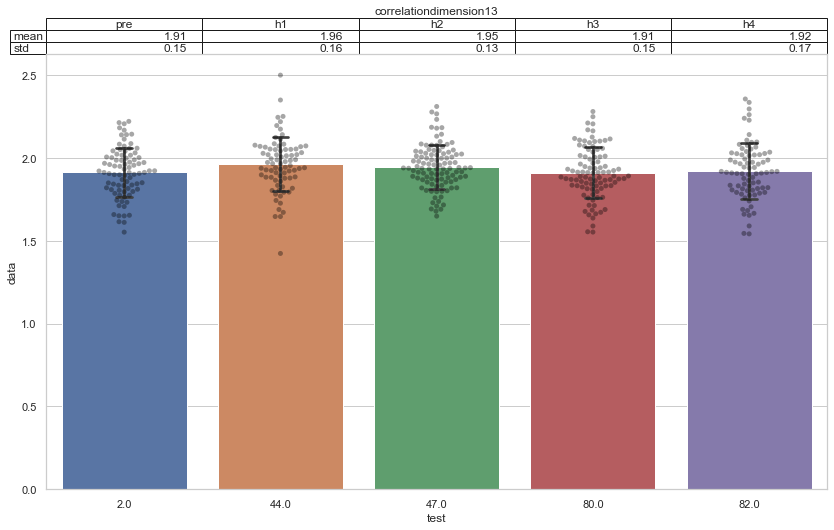

<Figure size 432x288 with 0 Axes>

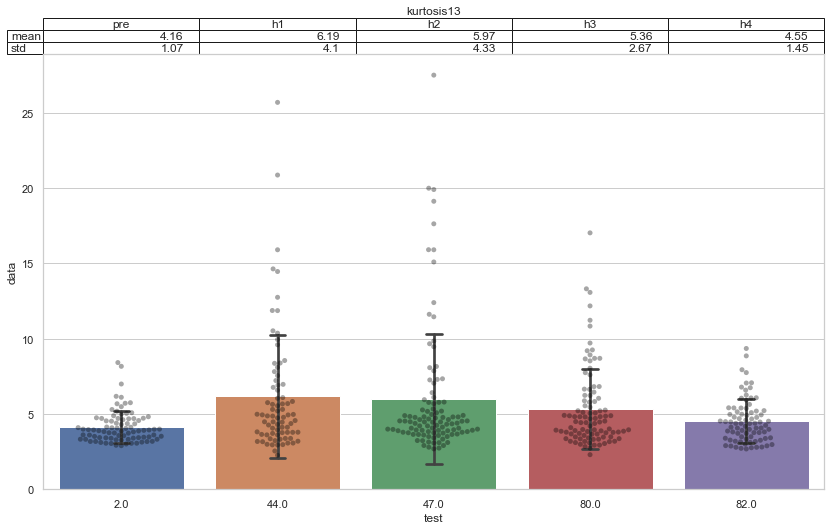

<Figure size 432x288 with 0 Axes>

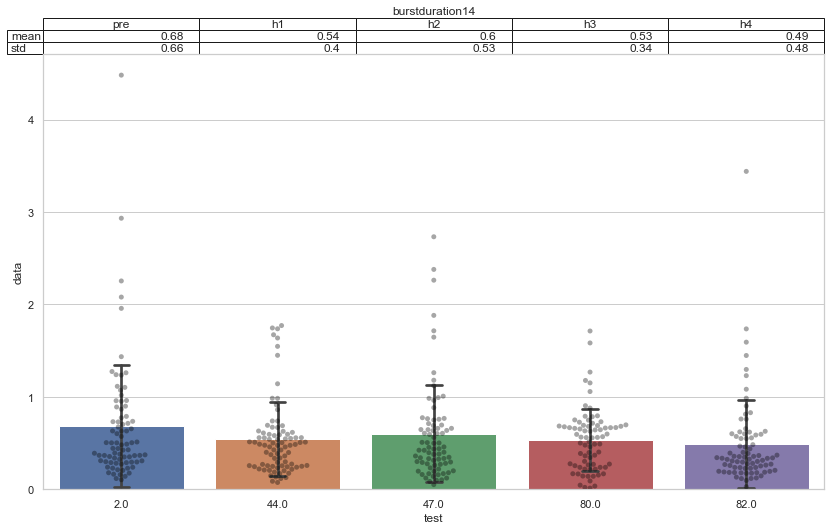

<Figure size 432x288 with 0 Axes>

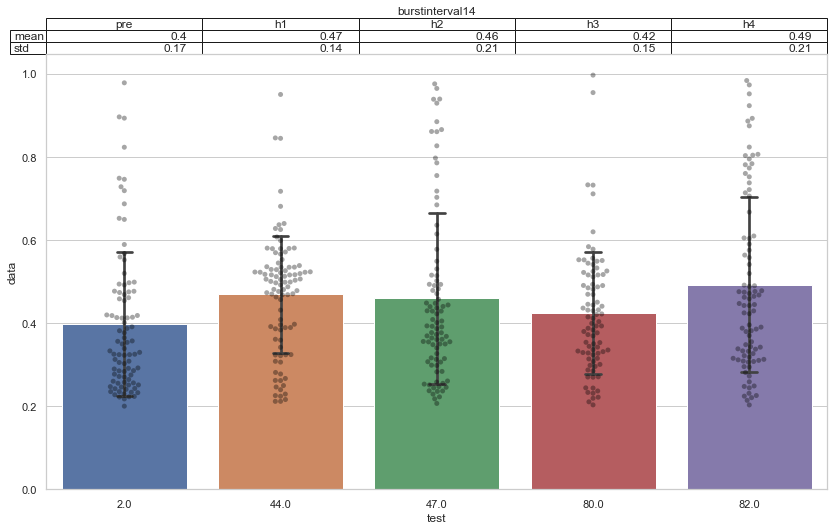

<Figure size 432x288 with 0 Axes>

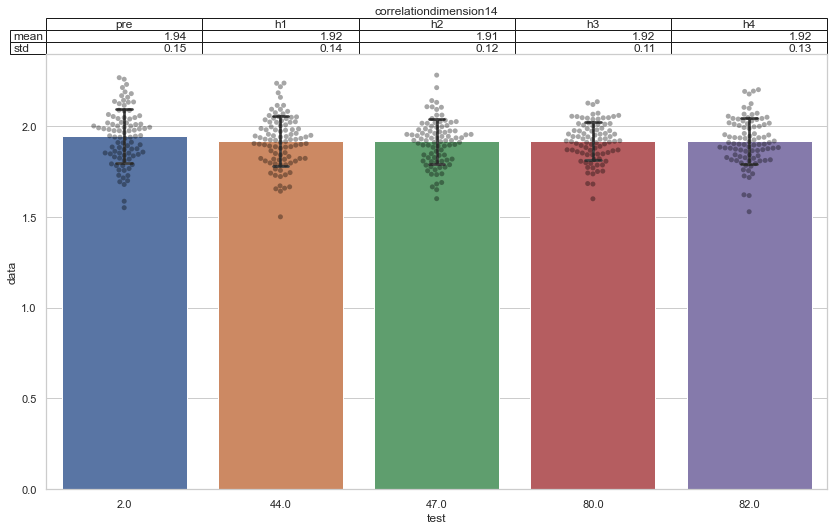

<Figure size 432x288 with 0 Axes>

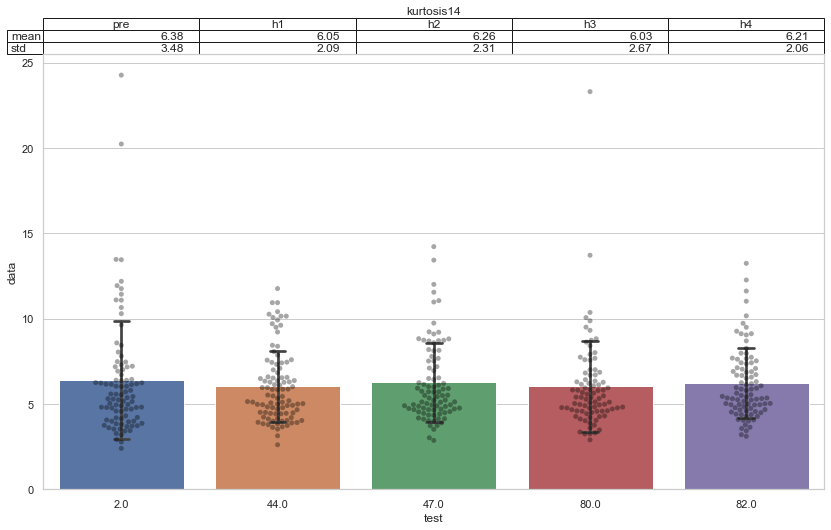

<Figure size 432x288 with 0 Axes>

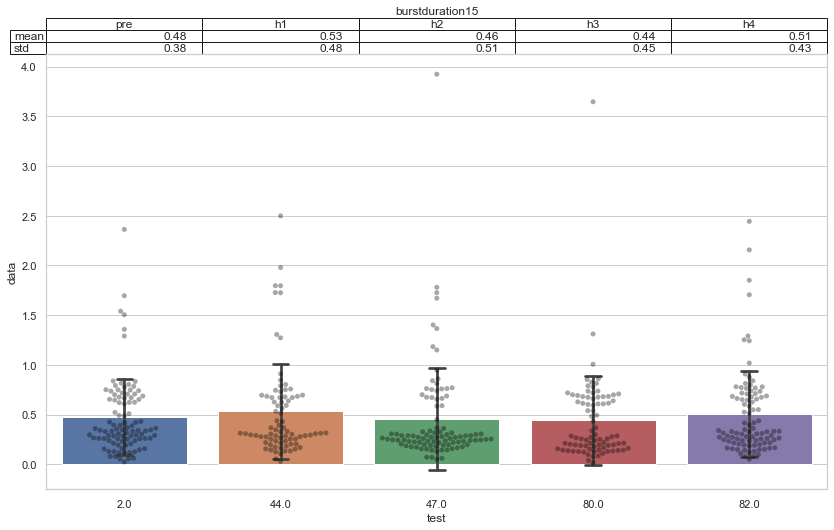

<Figure size 432x288 with 0 Axes>

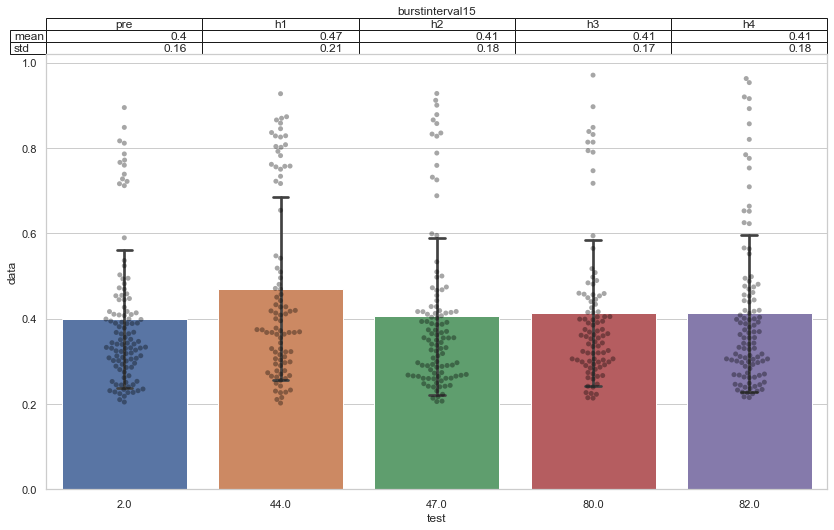

<Figure size 432x288 with 0 Axes>

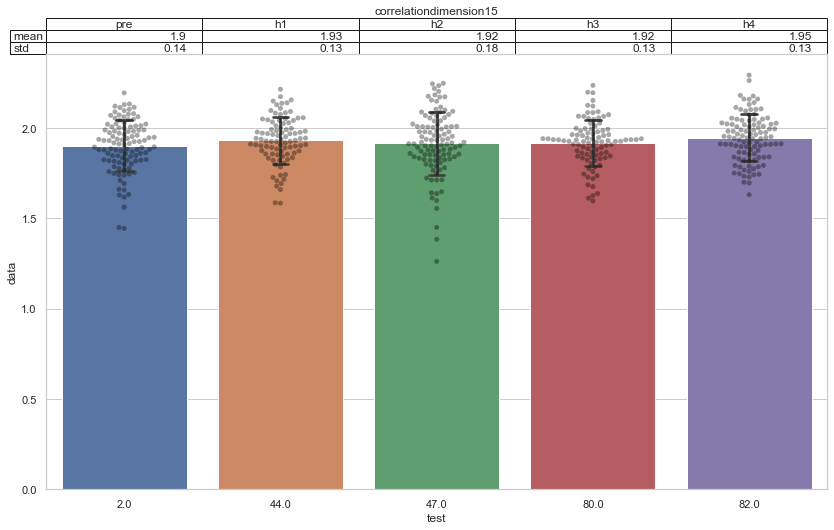

<Figure size 432x288 with 0 Axes>

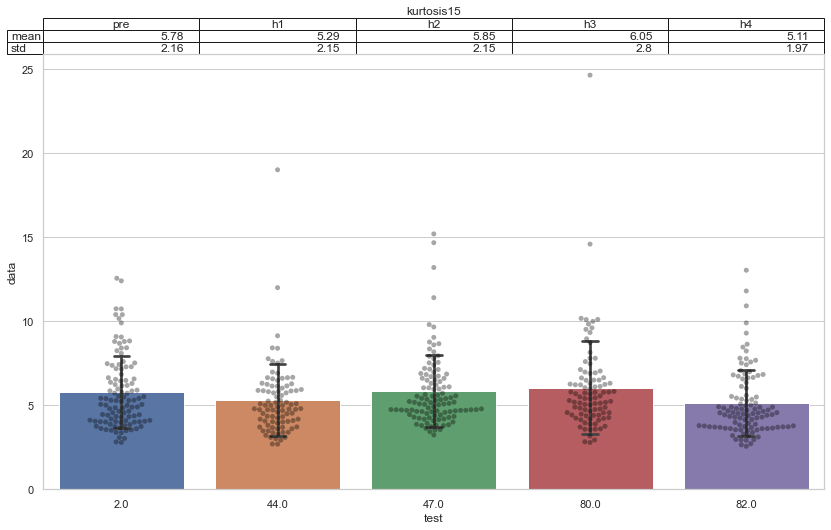

<Figure size 432x288 with 0 Axes>

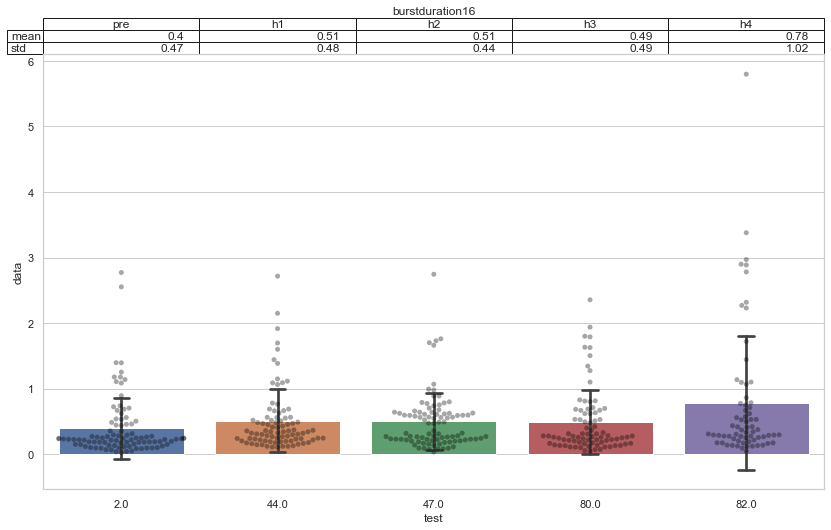

<Figure size 432x288 with 0 Axes>

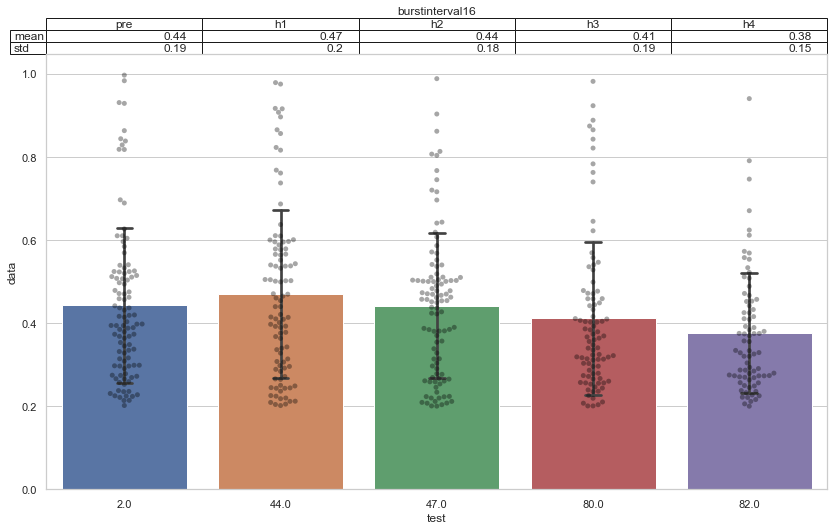

<Figure size 432x288 with 0 Axes>

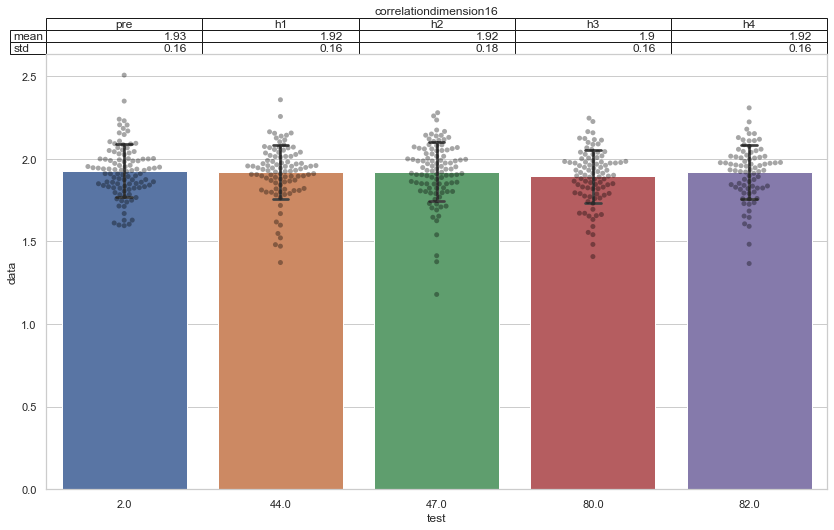

<Figure size 432x288 with 0 Axes>

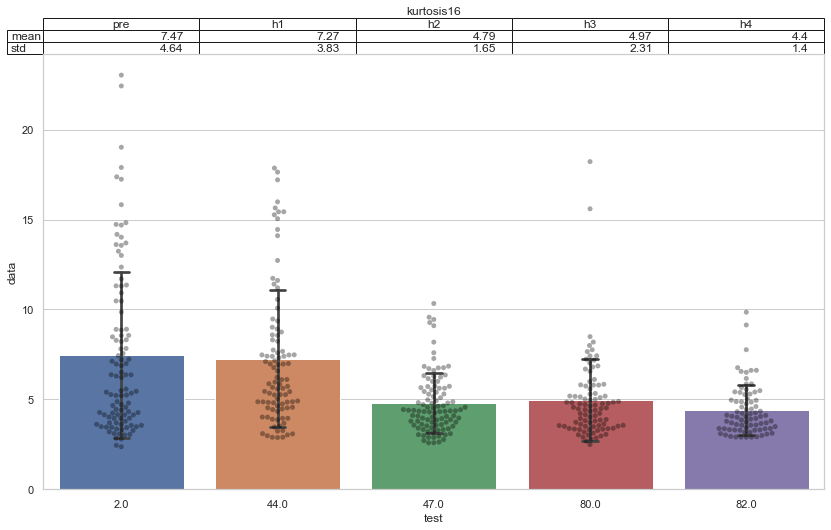

<Figure size 432x288 with 0 Axes>

In [37]:
df = pd.DataFrame()
data=[]
index=['burstduration','burstinterval','correlationdimension','kurtosis']
rows=["mean","std"]
for i in range(16):
    Data = pd.DataFrame()
    for filename in listdir(mypath):  
        fullpath = join(mypath,filename)
        name=fullpath.split("_")[testorder]   
        for t in test:
            if ((testname+str(t)) in name):
                data = pd.read_excel(fullpath, sheet_name=None)
                sheet = pd.ExcelFile(fullpath)               

                le=len(getburst(data)[4][i])                 
                my_array = np.array([np.full(le,int(t)),np.full(le,i),np.full(le,0),getburst(data)[4][i]])
                
                my_array=my_array.transpose((1, 0))
                df = pd.DataFrame(my_array, columns = ['test','pca','part','data'])
                Data=pd.concat([Data, df], axis=0)
                le=len(getburst(data)[5][i])                 
                my_array = np.array([np.full(le,int(t)),np.full(le,i),np.full(le,1),getburst(data)[5][i]])
                my_array=my_array.transpose((1, 0))
                df = pd.DataFrame(my_array, columns = ['test','pca','part','data'])
                Data=pd.concat([Data, df], axis=0)
                le=len(get_corr(data)[2][i])                 
                my_array = np.array([np.full(le,int(t)),np.full(le,i),np.full(le,2),get_corr(data)[2][i]])
                my_array=my_array.transpose((1, 0))
                df = pd.DataFrame(my_array, columns = ['test','pca','part','data'])
                Data=pd.concat([Data, df], axis=0)
                le=len(get_ku(data)[2][i])                 
                my_array = np.array([np.full(le,int(t)),np.full(le,i),np.full(le,3),get_ku(data)[2][i]])
                my_array=my_array.transpose((1, 0))
                df = pd.DataFrame(my_array, columns = ['test','pca','part','data'])
                Data=pd.concat([Data, df], axis=0)
                
    for k in range(4):                         
        fig, ax = plt.subplots(figsize = (14,8))
        sns.set(style="whitegrid")

        sns.barplot(x="test", y="data", data=Data[Data['pca'].isin([i])&Data['part'].isin([k])], capsize=.1, ci="sd")
        sns.swarmplot(x="test", y="data", data=Data[Data['pca'].isin([i])&Data['part'].isin([k])], color="0", alpha=.35)
        
        df=Data[Data['pca'].isin([i])&Data['part'].isin([k])]
        m=df.groupby(['test']).mean()['data']
        Mean = [round(item, 2) for item in m]
        s=df.groupby(['test']).std()['data']
        Std = [round(item, 2) for item in s]
        arr=[Mean,Std]
        
        plt.title(label=index[k]+str(i+1), 
                  fontweight=10, 
                  pad='40.0')

        the_table = plt.table(cellText=arr,
                          rowLabels=rows,
                          colLabels=label,
                          loc='top')
        fig.savefig(folder+'_bar_'+index[k]+str(i+1)+'.png',bbox_inches='tight',pad_inches=0.25,facecolor='w') 
        plt.show()
        plt.figure().clear()